### Prologue
Prepare the notebook for inline plotting<br>
Load required libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [1]:
from IPython.display import Image
%matplotlib inline

# experimental script
import pickle
from forest_surveyor.routines import grid_experiment

LOADING NEW DATA SET.

Finding best parameters for Random Forest. Checking for prior tuning parameters.

12 runs to do

starting new run at: Sat May 12 14:45:59 2018
{'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 500}
ending run at: Sat May 12 14:46:00 2018
completed 1 run(s)

starting new run at: Sat May 12 14:46:00 2018
{'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 1000}
ending run at: Sat May 12 14:46:01 2018
completed 2 run(s)

starting new run at: Sat May 12 14:46:01 2018
{'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 1500}
ending run at: Sat May 12 14:46:04 2018
completed 3 run(s)

starting new run at: Sat May 12 14:46:04 2018
{'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 500}
ending run at: Sat May 12 14:46:04 2018
completed 4 run(s)

starting new run at: Sat May 12 14:46:04 2018
{'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 1000}
ending run at: Sat May 12 14:46:06 2018
completed 5 run(s)

starting new run at: Sat May 12 14:46:06 2

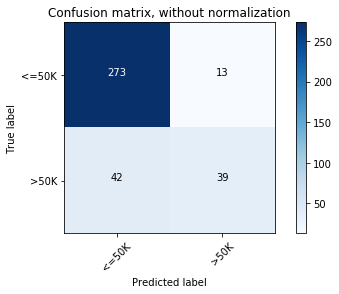

Normalized confusion matrix
[[0.95 0.05]
 [0.52 0.48]]


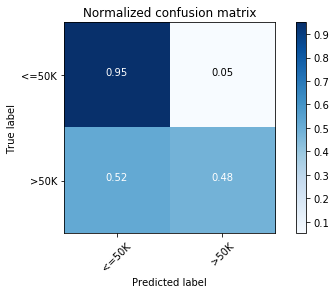

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 14:46:20 2018 with batch_size = 7 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 14:50:07 2018. Elapsed time (seconds) = 226.61211624800262

Compiling Training Results at: Sat May 12 14:50:07 2018...(please wait)
Results Completed at: Sat May 12 14:50:08 2018. Elapsed time (seconds) = 1.1805899175692218
Whiteboxing Randfor Done

Processing Anchors
Starti

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.8311
Cohen's Kappa on unseen instances: 0.4559

Precision: [0.86, 0.66]
Recall: [0.93, 0.48]
F1 Score: [0.9, 0.56]
Support: [286, 81]

Confusion matrix, without normalization
[[266  20]
 [ 42  39]]


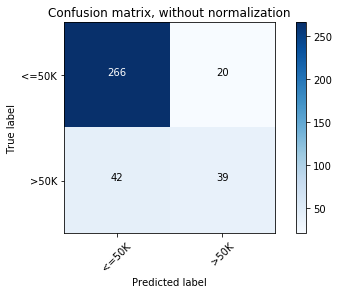

Normalized confusion matrix
[[0.93 0.07]
 [0.52 0.48]]


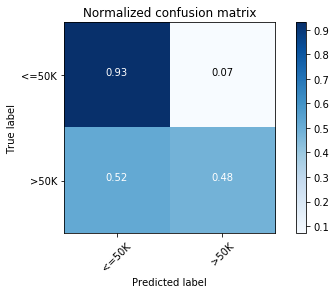

Working on Anchors for instance 356


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 674
Working on Anchors for instance 260
Working on Anchors for instance 960
Working on Anchors for instance 204
Working on Anchors for instance 681
Working on Anchors for instance 449
Working on Anchors for instance 620
Working on Anchors for instance 1051
Working on Anchors for instance 512
Working on Anchors for instance 927
Working on Anchors for instance 614
Working on Anchors for instance 18
Working on Anchors for instance 528
Working on Anchors for instance 167
Working on Anchors for instance 103
Working on Anchors for instance 821
Working on Anchors for instance 698
Working on Anchors for instance 186
Working on Anchors for instance 453
Working on Anchors for instance 289
Working on Anchors for instance 1187
Working on Anchors for instance 597
Working on Anchors for instance 182
Working on Anchors for instance 119
Working on Anchors for instance 882
Working on Anchors for instance 1066
Working on Anchors for instance 517
Working on Anchors for ins

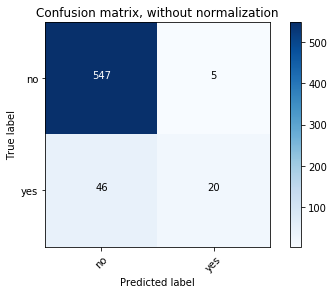

Normalized confusion matrix
[[0.99 0.01]
 [0.7  0.3 ]]


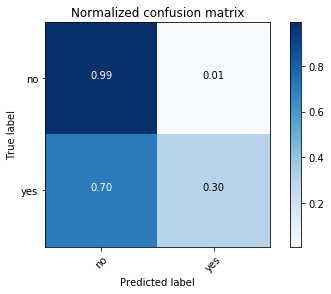

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 14:56:48 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 15:08:21 2018. Elapsed time (seconds) = 692.5530028009757

Compiling Training Results at: Sat May 12 15:08:21 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 15:08:23 2018. Elapsed time (seconds) = 1.9794935648469618
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 15:08:23 2018

Best OOB Cohen's Kappa during tuning: 0.9126
Best parameters: {'max_depth': 16, 'min_samples_leaf': 5, 'n_estimators': 1500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9078
Cohen's Kappa on unseen instances: 0.2673

Precision: [0.91, 0.8]
Recall: [0.99, 0.18]
F1 Score: [0.95, 0.3]
Support: [552, 66]

Confusion matrix, without normalization
[[549   3]
 [ 54  12]]


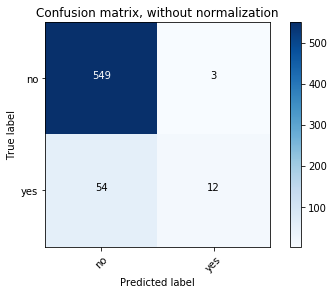

Normalized confusion matrix
[[0.99 0.01]
 [0.82 0.18]]


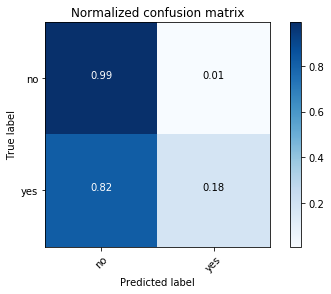

Working on Anchors for instance 1921
Working on Anchors for instance 558
Working on Anchors for instance 1721
Working on Anchors for instance 2012
Working on Anchors for instance 1790
Working on Anchors for instance 1871
Working on Anchors for instance 1035
Working on Anchors for instance 805
Working on Anchors for instance 1476
Working on Anchors for instance 2019
Working on Anchors for instance 91
Working on Anchors for instance 1251
Working on Anchors for instance 1196
Working on Anchors for instance 1684
Working on Anchors for instance 1216
Working on Anchors for instance 356
Working on Anchors for instance 1796
Working on Anchors for instance 1064
Working on Anchors for instance 235
Working on Anchors for instance 63
Working on Anchors for instance 1895
Working on Anchors for instance 982
Working on Anchors for instance 278
Working on Anchors for instance 1851
Working on Anchors for instance 1266
Working on Anchors for instance 1454
Working on Anchors for instance 702
Working on A

C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1544
Working on Anchors for instance 1947
Working on Anchors for instance 54
Working on Anchors for instance 1094
Working on Anchors for instance 437
Working on Anchors for instance 949
Working on Anchors for instance 1316
Working on Anchors for instance 320
Working on Anchors for instance 1740
Working on Anchors for instance 5
Working on Anchors for instance 895
Working on Anchors for instance 2032
Anchors Done. Completed run at: Sat May 12 15:21:22 2018. Elapsed time (seconds) = 779.499201652822

Results saved at whiteboxing\bankmark_samp_pickles\results.pickle

To retrieve results execute the following:
results_store = open('whiteboxing\bankmark_samp_pickles\results.pickle', "rb")
results = pickle.load(results_store)
results_store.close()

LOADING NEW DATA SET.

Finding best parameters for Random Forest. Checking for prior tuning parameters.

12 runs to do

starting new run at: Sat May 12 15:21:23 2018
{'max_depth': 8, 'min_samples_leaf': 1, 'n_estima

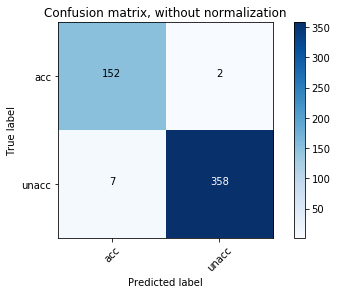

Normalized confusion matrix
[[0.99 0.01]
 [0.02 0.98]]


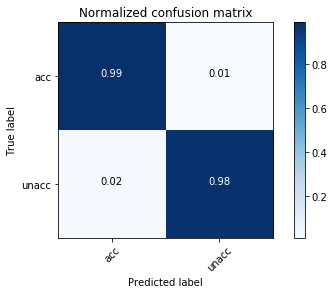

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 15:21:44 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 15:32:27 2

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9827
Cohen's Kappa on unseen instances: 0.9588

Precision: [0.96, 0.99]
Recall: [0.99, 0.98]
F1 Score: [0.97, 0.99]
Support: [154, 365]

Confusion matrix, without normalization
[[152   2]
 [  7 358]]


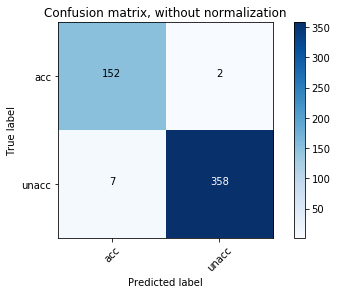

Normalized confusion matrix
[[0.99 0.01]
 [0.02 0.98]]


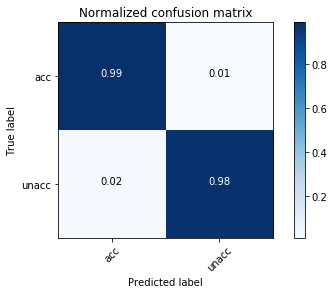

Working on Anchors for instance 1481
Working on Anchors for instance 1390
Working on Anchors for instance 1121
Working on Anchors for instance 120


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1677
Working on Anchors for instance 1009
Working on Anchors for instance 1212
Working on Anchors for instance 637
Working on Anchors for instance 1487
Working on Anchors for instance 981
Working on Anchors for instance 1179
Working on Anchors for instance 31
Working on Anchors for instance 985
Working on Anchors for instance 206
Working on Anchors for instance 129
Working on Anchors for instance 1377
Working on Anchors for instance 499
Working on Anchors for instance 905
Working on Anchors for instance 1659
Working on Anchors for instance 63
Working on Anchors for instance 689
Working on Anchors for instance 927
Working on Anchors for instance 1120
Working on Anchors for instance 866
Working on Anchors for instance 134
Working on Anchors for instance 650
Working on Anchors for instance 249
Working on Anchors for instance 1372
Working on Anchors for instance 1000
Working on Anchors for instance 328
Working on Anchors for instance 1337
Working on Anchors 

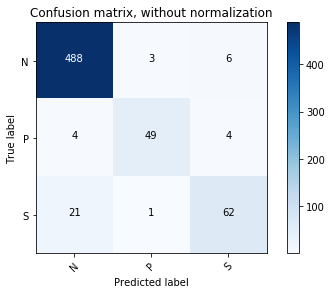

Normalized confusion matrix
[[0.98 0.01 0.01]
 [0.07 0.86 0.07]
 [0.25 0.01 0.74]]


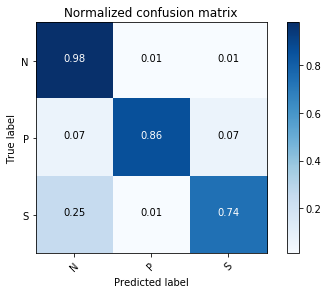

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 15:44:35 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 15:57:14 2018. Elapsed time (seconds) = 759.0454237609993

Compiling Training Results at: Sat May 12 15:57:14 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 15:57:15 2018. Elapsed time (seconds) = 1.2573060635331785
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 15:57:15 2018

Best OOB Cohen's Kappa during tuning: 0.9462
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 1500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9185
Cohen's Kappa on unseen instances: 0.7633

Precision: [0.94, 0.91, 0.77]
Recall: [0.98, 0.86, 0.58]
F1 Score: [0.96, 0.88, 0.66]
Support: [497, 57, 84]

Confusion matrix, without normalization
[[488   0   9]
 [  2  49   6]
 [ 30   5  49]]


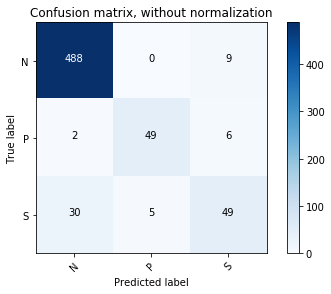

Normalized confusion matrix
[[0.98 0.   0.02]
 [0.04 0.86 0.11]
 [0.36 0.06 0.58]]


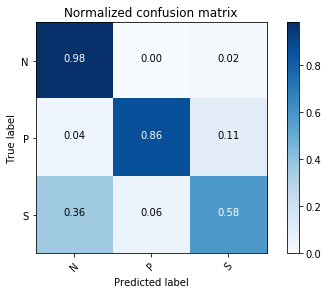

Working on Anchors for instance 961
Working on Anchors for instance 1696


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1614
Working on Anchors for instance 1477
Working on Anchors for instance 861
Working on Anchors for instance 449
Working on Anchors for instance 43
Working on Anchors for instance 1174
Working on Anchors for instance 1060
Working on Anchors for instance 1052
Working on Anchors for instance 1335
Working on Anchors for instance 988
Working on Anchors for instance 963
Working on Anchors for instance 1733
Working on Anchors for instance 1976
Working on Anchors for instance 1622
Working on Anchors for instance 1414
Working on Anchors for instance 605
Working on Anchors for instance 585
Working on Anchors for instance 1682
Working on Anchors for instance 1041
Working on Anchors for instance 1624
Working on Anchors for instance 985
Working on Anchors for instance 28
Working on Anchors for instance 318
Working on Anchors for instance 803
Working on Anchors for instance 1311
Working on Anchors for instance 1251
Working on Anchors for instance 458
Working on Anch

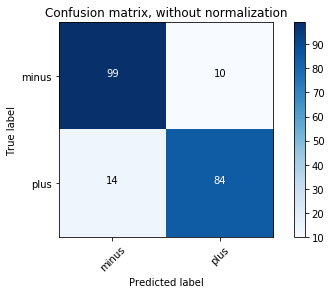

Normalized confusion matrix
[[0.91 0.09]
 [0.14 0.86]]


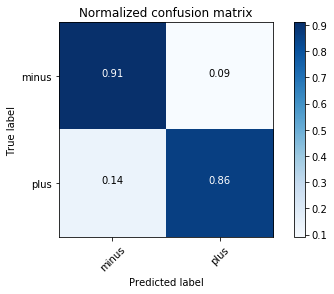

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 17:06:30 2018 with batch_size = 4 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 17:08:04 2018. Elapsed time (seconds) = 94.10629886007882

Compiling Training Results at: Sat May 12 17:08:04 2018...(please wait)
Results Completed at: Sat May 12 17:08:04 2018. Elapsed time (seconds) = 0.5581050717428298
Whiteboxing Randfor Done

Processing Anchors
Startin

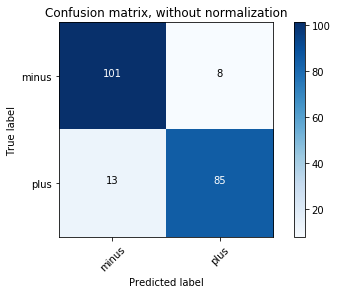

Normalized confusion matrix
[[0.93 0.07]
 [0.13 0.87]]


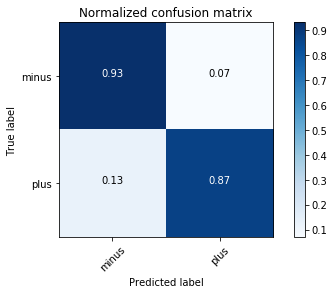

Working on Anchors for instance 399
Working on Anchors for instance 689
Working on Anchors for instance 182
Working on Anchors for instance 283
Working on Anchors for instance 563
Working on Anchors for instance 601
Working on Anchors for instance 679
Working on Anchors for instance 292
Working on Anchors for instance 610
Working on Anchors for instance 368
Working on Anchors for instance 85
Working on Anchors for instance 641
Working on Anchors for instance 664
Working on Anchors for instance 336
Working on Anchors for instance 237
Working on Anchors for instance 185
Working on Anchors for instance 147
Working on Anchors for instance 101
Working on Anchors for instance 145
Working on Anchors for instance 568
Anchors Done. Completed run at: Sat May 12 17:11:24 2018. Elapsed time (seconds) = 199.75627034553509

Results saved at whiteboxing\credit_pickles\results.pickle

To retrieve results execute the following:
results_store = open('whiteboxing\credit_pickles\results.pickle', "rb")
res

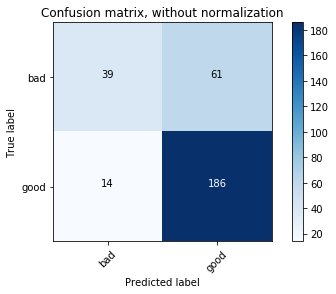

Normalized confusion matrix
[[0.39 0.61]
 [0.07 0.93]]


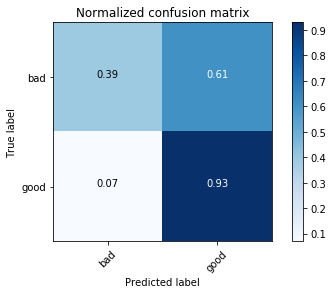

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 17:11:48 2018 with batch_size = 6 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 17:17:59 2018. Elapsed time (seconds) = 370.6189978985185

Compiling Training Results at: Sat May 12 17:17:59 2018...(please wait)
Results Completed at: Sat May 12 17:18:00 2018. Elapsed time (seconds) = 1.5769372914364794
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 17:18:00 2018


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.7533
Cohen's Kappa on unseen instances: 0.3729

Precision: [0.74, 0.76]
Recall: [0.4, 0.93]
F1 Score: [0.52, 0.83]
Support: [100, 200]

Confusion matrix, without normalization
[[ 40  60]
 [ 14 186]]


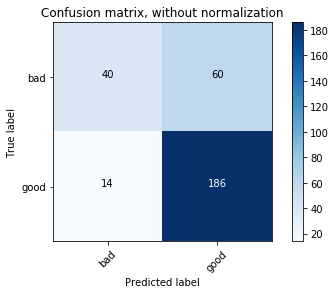

Normalized confusion matrix
[[0.4  0.6 ]
 [0.07 0.93]]


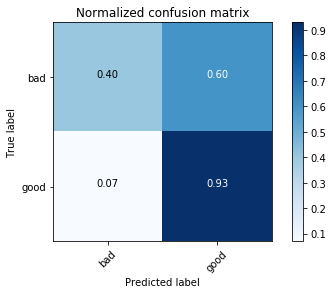

Working on Anchors for instance 131


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 195
Working on Anchors for instance 372
Working on Anchors for instance 722
Working on Anchors for instance 771
Working on Anchors for instance 161
Working on Anchors for instance 803
Working on Anchors for instance 345
Working on Anchors for instance 437
Working on Anchors for instance 640
Working on Anchors for instance 875
Working on Anchors for instance 828
Working on Anchors for instance 891
Working on Anchors for instance 953
Working on Anchors for instance 298
Working on Anchors for instance 923
Working on Anchors for instance 204
Working on Anchors for instance 807
Working on Anchors for instance 456
Working on Anchors for instance 388
Working on Anchors for instance 512
Working on Anchors for instance 75
Working on Anchors for instance 881
Working on Anchors for instance 13
Working on Anchors for instance 920
Working on Anchors for instance 894
Working on Anchors for instance 273
Working on Anchors for instance 107
Working on Anchors for instanc

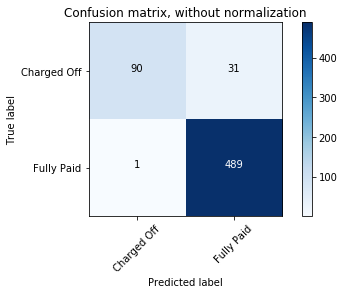

Normalized confusion matrix
[[0.74 0.26]
 [0.   1.  ]]


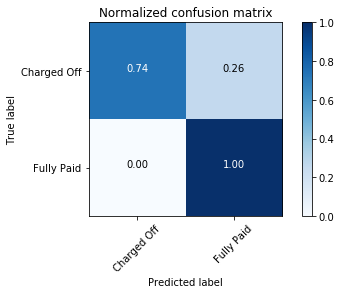

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 17:41:28 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 17:46:45 2018. Elapsed time (seconds) = 317.31881184786835

Compiling Training Results at: Sat May 12 17:46:45 2018...(please wait)
Results Completed at: Sat May 12 17:46:48 2018. Elapsed time (seconds) = 2.2917978465957276
Whiteboxing Randfor Done

Processing Anchors
Starti

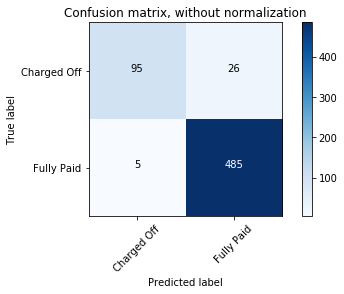

Normalized confusion matrix
[[0.79 0.21]
 [0.01 0.99]]


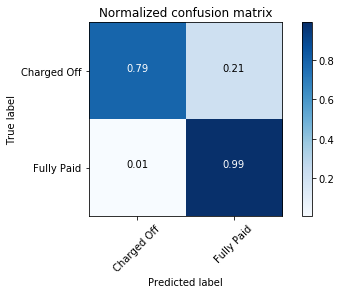

Working on Anchors for instance 489
Working on Anchors for instance 1965
Working on Anchors for instance 381
Working on Anchors for instance 1368
Working on Anchors for instance 1337
Working on Anchors for instance 777
Working on Anchors for instance 701
Working on Anchors for instance 850
Working on Anchors for instance 91
Working on Anchors for instance 1599
Working on Anchors for instance 1181
Working on Anchors for instance 64
Working on Anchors for instance 613


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1315
Working on Anchors for instance 1873
Working on Anchors for instance 870
Working on Anchors for instance 182
Working on Anchors for instance 1830
Working on Anchors for instance 1109
Working on Anchors for instance 847
Working on Anchors for instance 309
Working on Anchors for instance 1994
Working on Anchors for instance 807
Working on Anchors for instance 882
Working on Anchors for instance 841
Working on Anchors for instance 1727
Working on Anchors for instance 466
Working on Anchors for instance 520
Working on Anchors for instance 970
Working on Anchors for instance 893
Working on Anchors for instance 1547
Working on Anchors for instance 1188
Working on Anchors for instance 1630
Working on Anchors for instance 803
Working on Anchors for instance 1116
Working on Anchors for instance 524
Working on Anchors for instance 1812
Working on Anchors for instance 129
Working on Anchors for instance 1294
Working on Anchors for instance 1022
Working on Anch

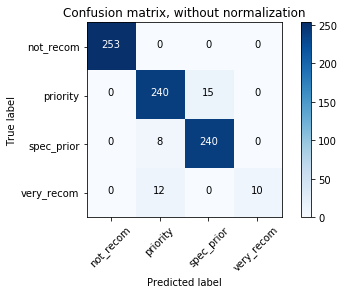

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.94 0.06 0.  ]
 [0.   0.03 0.97 0.  ]
 [0.   0.55 0.   0.45]]


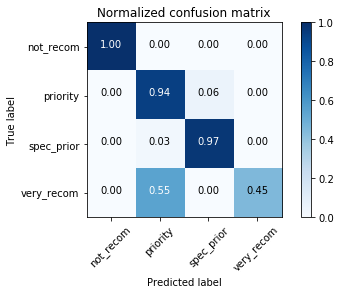

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 18:27:32 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 18:41:29 2018. Elapsed time (seconds) = 837.1050876679546

Compiling Training Results at: Sat May 12 18:41:29 2018...(please wait)
Results Completed at: Sat May 12 18:41:30 2018. Elapsed time (seconds) = 1.141985008980555
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 18:41:30 2018

Best OOB Cohen's Kappa during tuning: 0.9625
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9550
Cohen's Kappa on unseen instances: 0.9338

Precision: [1.0, 0.92, 0.94, 1.0]
Recall: [1.0, 0.94, 0.97, 0.45]
F1 Score: [1.0, 0.93, 0.95, 0.62]
Support: [253, 255, 248, 22]

Confusion matrix, without normalization
[[253   0   0   0]
 [  0 240  15   0]
 [  0   8 240   0]
 [  0  12   0  10]]


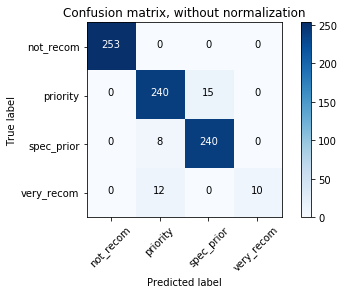

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.94 0.06 0.  ]
 [0.   0.03 0.97 0.  ]
 [0.   0.55 0.   0.45]]


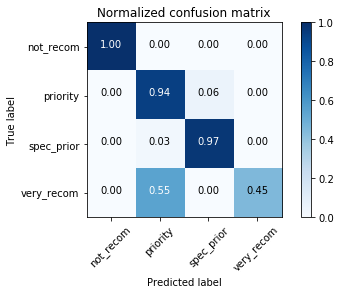

Working on Anchors for instance 33
Working on Anchors for instance 2300
Working on Anchors for instance 379


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 2347
Working on Anchors for instance 403
Working on Anchors for instance 440
Working on Anchors for instance 1501
Working on Anchors for instance 1951
Working on Anchors for instance 2325
Working on Anchors for instance 813
Working on Anchors for instance 673
Working on Anchors for instance 2424
Working on Anchors for instance 1000
Working on Anchors for instance 746
Working on Anchors for instance 252
Working on Anchors for instance 2330
Working on Anchors for instance 1628
Working on Anchors for instance 132
Working on Anchors for instance 2110
Working on Anchors for instance 2526
Working on Anchors for instance 649
Working on Anchors for instance 1185
Working on Anchors for instance 2362
Working on Anchors for instance 2358
Working on Anchors for instance 2349
Working on Anchors for instance 1791
Working on Anchors for instance 1533
Working on Anchors for instance 1801
Working on Anchors for instance 1729
Working on Anchors for instance 1338
Working o

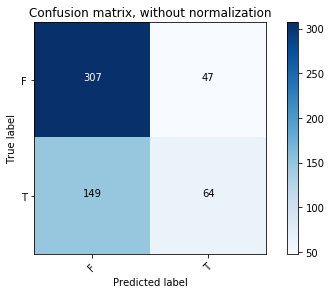

Normalized confusion matrix
[[0.87 0.13]
 [0.7  0.3 ]]


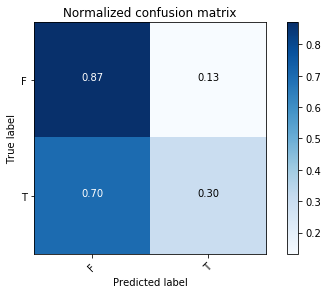

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 18:50:50 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 18:54:39 2018. Elapsed time (seconds) = 229.0110620811829

Compiling Training Results at: Sat May 12 18:54:39 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 18:54:40 2018. Elapsed time (seconds) = 0.9494583438245172
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 18:54:40 2018

Best OOB Cohen's Kappa during tuning: 0.6525
Best parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.6384
Cohen's Kappa on unseen instances: 0.1364

Precision: [0.66, 0.54]
Recall: [0.87, 0.25]
F1 Score: [0.75, 0.34]
Support: [354, 213]

Confusion matrix, without normalization
[[309  45]
 [160  53]]


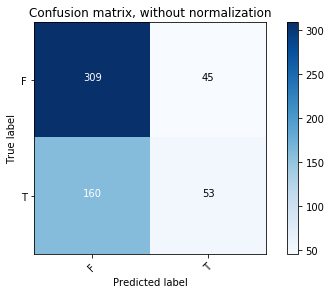

Normalized confusion matrix
[[0.87 0.13]
 [0.75 0.25]]


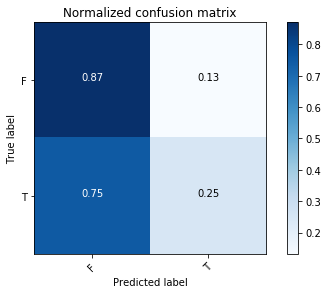

Working on Anchors for instance 1678
Working on Anchors for instance 1644
Working on Anchors for instance 104


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1738
Working on Anchors for instance 1692
Working on Anchors for instance 1463
Working on Anchors for instance 1470
Working on Anchors for instance 304
Working on Anchors for instance 1177
Working on Anchors for instance 1264
Working on Anchors for instance 674
Working on Anchors for instance 871
Working on Anchors for instance 218
Working on Anchors for instance 1690
Working on Anchors for instance 266
Working on Anchors for instance 935
Working on Anchors for instance 1625
Working on Anchors for instance 1190
Working on Anchors for instance 778
Working on Anchors for instance 1212
Working on Anchors for instance 320
Working on Anchors for instance 1342
Working on Anchors for instance 499
Working on Anchors for instance 1207
Working on Anchors for instance 1340
Working on Anchors for instance 813
Working on Anchors for instance 1864
Working on Anchors for instance 1810
Working on Anchors for instance 54
Working on Anchors for instance 270
Working on Anc

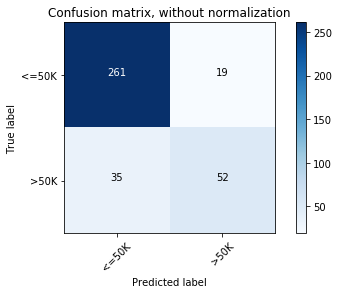

Normalized confusion matrix
[[0.93 0.07]
 [0.4  0.6 ]]


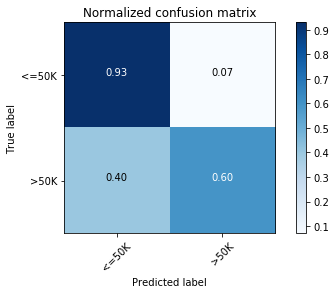

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 19:05:34 2018 with batch_size = 7 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 19:14:20 2018. Elapsed time (seconds) = 526.1968897812148

Compiling Training Results at: Sat May 12 19:14:20 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 19:14:21 2018. Elapsed time (seconds) = 1.361962557908555
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 19:14:21 2018

Best OOB Cohen's Kappa during tuning: 0.8407
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.8174
Cohen's Kappa on unseen instances: 0.4851

Precision: [0.87, 0.62]
Recall: [0.89, 0.59]
F1 Score: [0.88, 0.6]
Support: [280, 87]

Confusion matrix, without normalization
[[249  31]
 [ 36  51]]


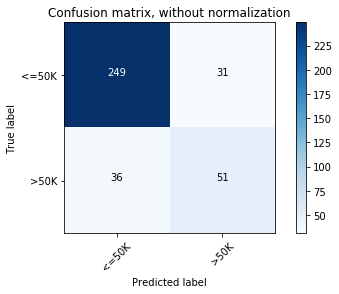

Normalized confusion matrix
[[0.89 0.11]
 [0.41 0.59]]


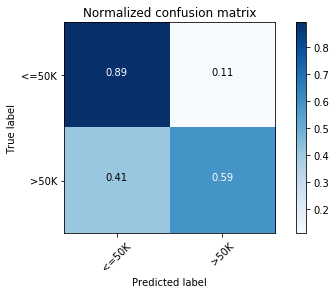

Working on Anchors for instance 1208


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1165
Working on Anchors for instance 863
Working on Anchors for instance 947
Working on Anchors for instance 909
Working on Anchors for instance 877
Working on Anchors for instance 1014
Working on Anchors for instance 317
Working on Anchors for instance 765
Working on Anchors for instance 983
Working on Anchors for instance 547
Working on Anchors for instance 81
Working on Anchors for instance 752
Working on Anchors for instance 670
Working on Anchors for instance 302
Working on Anchors for instance 1148
Working on Anchors for instance 838
Working on Anchors for instance 1159
Working on Anchors for instance 451
Working on Anchors for instance 598
Working on Anchors for instance 1096
Working on Anchors for instance 354
Working on Anchors for instance 70
Working on Anchors for instance 1203
Working on Anchors for instance 1106
Working on Anchors for instance 410
Working on Anchors for instance 1204
Working on Anchors for instance 1048
Working on Anchors fo

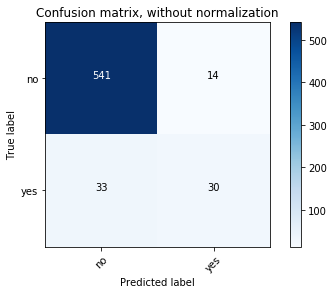

Normalized confusion matrix
[[0.97 0.03]
 [0.52 0.48]]


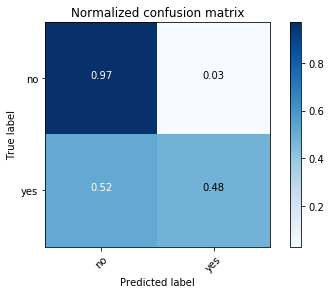

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 19:23:55 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 19:34:10 2018. Elapsed time (seconds) = 615.3873110573331

Compiling Training Results at: Sat May 12 19:34:10 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 19:34:12 2018. Elapsed time (seconds) = 1.8728557752911001
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 19:34:12 2018

Best OOB Cohen's Kappa during tuning: 0.9146
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 1000}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9256
Cohen's Kappa on unseen instances: 0.4847

Precision: [0.94, 0.76]
Recall: [0.99, 0.4]
F1 Score: [0.96, 0.52]
Support: [555, 63]

Confusion matrix, without normalization
[[547   8]
 [ 38  25]]


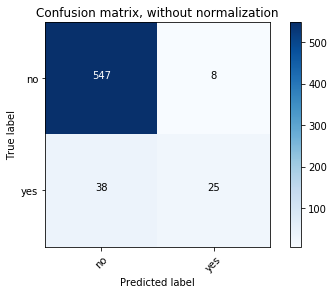

Normalized confusion matrix
[[0.99 0.01]
 [0.6  0.4 ]]


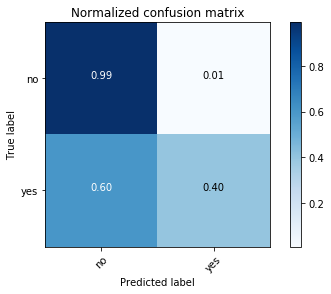

Working on Anchors for instance 623
Working on Anchors for instance 1393
Working on Anchors for instance 717


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1788
Working on Anchors for instance 1994
Working on Anchors for instance 861
Working on Anchors for instance 946
Working on Anchors for instance 1796
Working on Anchors for instance 1760
Working on Anchors for instance 536
Working on Anchors for instance 368
Working on Anchors for instance 1693
Working on Anchors for instance 1646
Working on Anchors for instance 2028
Working on Anchors for instance 615
Working on Anchors for instance 352
Working on Anchors for instance 1733
Working on Anchors for instance 673
Working on Anchors for instance 969
Working on Anchors for instance 1540
Working on Anchors for instance 1738
Working on Anchors for instance 1122
Working on Anchors for instance 1187
Working on Anchors for instance 1219
Working on Anchors for instance 1856
Working on Anchors for instance 802
Working on Anchors for instance 404
Working on Anchors for instance 127
Working on Anchors for instance 92
Working on Anchors for instance 784
Working on Anch

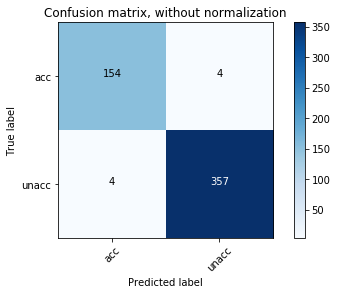

Normalized confusion matrix
[[0.97 0.03]
 [0.01 0.99]]


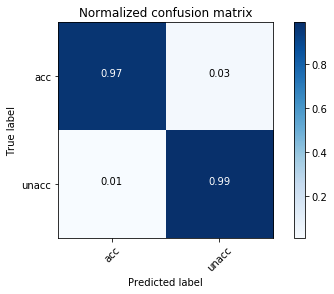

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 19:48:09 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 19:56:43 2

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9846
Cohen's Kappa on unseen instances: 0.9636

Precision: [0.97, 0.99]
Recall: [0.97, 0.99]
F1 Score: [0.97, 0.99]
Support: [158, 361]

Confusion matrix, without normalization
[[154   4]
 [  4 357]]


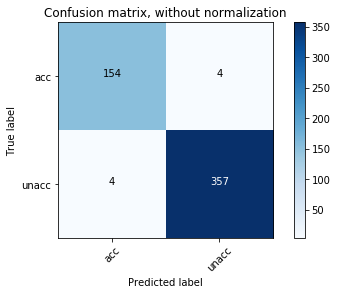

Normalized confusion matrix
[[0.97 0.03]
 [0.01 0.99]]


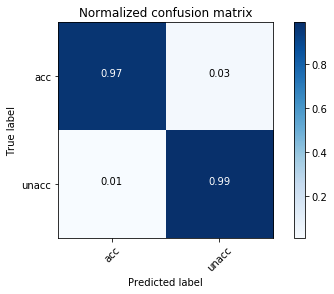

Working on Anchors for instance 1698
Working on Anchors for instance 625
Working on Anchors for instance 899
Working on Anchors for instance 1353
Working on Anchors for instance 1442


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 693
Working on Anchors for instance 1584
Working on Anchors for instance 1070
Working on Anchors for instance 1529
Working on Anchors for instance 610
Working on Anchors for instance 1317
Working on Anchors for instance 860
Working on Anchors for instance 940
Working on Anchors for instance 628
Working on Anchors for instance 16
Working on Anchors for instance 770
Working on Anchors for instance 1407
Working on Anchors for instance 495
Working on Anchors for instance 843
Working on Anchors for instance 1575
Working on Anchors for instance 1611
Working on Anchors for instance 652
Working on Anchors for instance 1055
Working on Anchors for instance 1449
Working on Anchors for instance 727
Working on Anchors for instance 280
Working on Anchors for instance 677
Working on Anchors for instance 288
Working on Anchors for instance 1692
Working on Anchors for instance 1259
Working on Anchors for instance 1357
Working on Anchors for instance 232
Working on Anchor

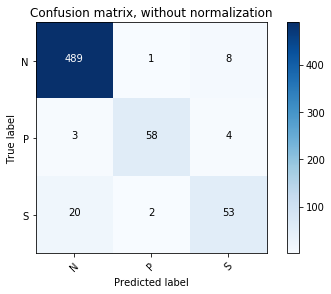

Normalized confusion matrix
[[0.98 0.   0.02]
 [0.05 0.89 0.06]
 [0.27 0.03 0.71]]


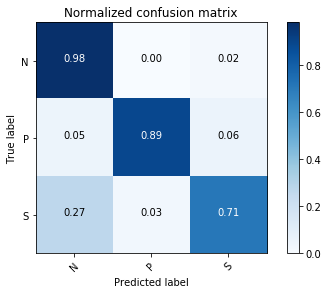

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 20:03:03 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 20:08:40 2018. Elapsed time (seconds) = 336.7684528770842

Compiling Training Results at: Sat May 12 20:08:40 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 20:08:41 2018. Elapsed time (seconds) = 1.0768134980462492
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 20:08:41 2018

Best OOB Cohen's Kappa during tuning: 0.9469
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9154
Cohen's Kappa on unseen instances: 0.7586

Precision: [0.95, 0.92, 0.68]
Recall: [0.98, 0.71, 0.68]
F1 Score: [0.96, 0.8, 0.68]
Support: [498, 65, 75]

Confusion matrix, without normalization
[[487   0  11]
 [  6  46  13]
 [ 20   4  51]]


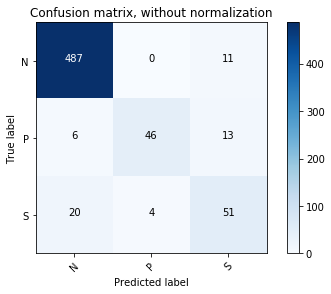

Normalized confusion matrix
[[0.98 0.   0.02]
 [0.09 0.71 0.2 ]
 [0.27 0.05 0.68]]


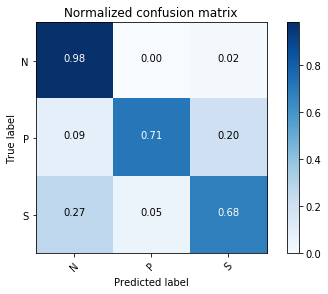

Working on Anchors for instance 1145
Working on Anchors for instance 1219


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1430
Working on Anchors for instance 2116
Working on Anchors for instance 526
Working on Anchors for instance 2060
Working on Anchors for instance 1139
Working on Anchors for instance 114
Working on Anchors for instance 1475
Working on Anchors for instance 502
Working on Anchors for instance 972
Working on Anchors for instance 352
Working on Anchors for instance 1356
Working on Anchors for instance 802
Working on Anchors for instance 536
Working on Anchors for instance 24
Working on Anchors for instance 327
Working on Anchors for instance 2125
Working on Anchors for instance 70
Working on Anchors for instance 1971
Working on Anchors for instance 2109
Working on Anchors for instance 240
Working on Anchors for instance 122
Working on Anchors for instance 741
Working on Anchors for instance 374
Working on Anchors for instance 752
Working on Anchors for instance 1159
Working on Anchors for instance 1338
Working on Anchors for instance 1448
Working on Anchors

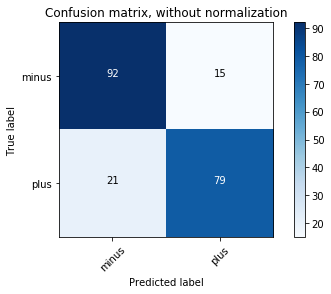

Normalized confusion matrix
[[0.86 0.14]
 [0.21 0.79]]


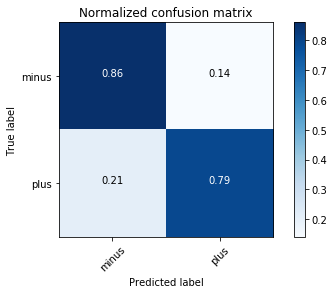

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 20:35:03 2018 with batch_size = 4 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 20:38:24 2018. Elapsed time (seconds) = 200.3661748383347

Compiling Training Results at: Sat May 12 20:38:24 2018...(please wait)
Results Completed at: Sat May 12 20:38:24 2018. Elapsed time (seconds) = 0.6504260956462531
Whiteboxing Randfor Done

Processing Anchors
Startin

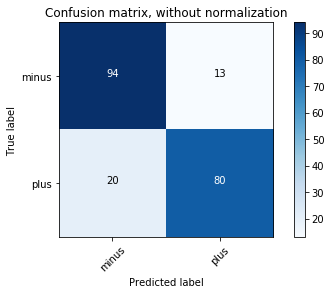

Normalized confusion matrix
[[0.88 0.12]
 [0.2  0.8 ]]


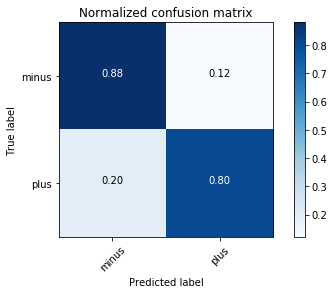

Working on Anchors for instance 483
Working on Anchors for instance 612
Working on Anchors for instance 370
Working on Anchors for instance 285
Working on Anchors for instance 486
Working on Anchors for instance 139
Working on Anchors for instance 664
Working on Anchors for instance 613


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 226
Working on Anchors for instance 87
Working on Anchors for instance 167
Working on Anchors for instance 268
Working on Anchors for instance 441
Working on Anchors for instance 195
Working on Anchors for instance 129
Working on Anchors for instance 193
Working on Anchors for instance 512
Working on Anchors for instance 45
Working on Anchors for instance 218
Working on Anchors for instance 92
Anchors Done. Completed run at: Sat May 12 20:50:56 2018. Elapsed time (seconds) = 751.7710534396829

Results saved at whiteboxing\credit_pickles\results.pickle

To retrieve results execute the following:
results_store = open('whiteboxing\credit_pickles\results.pickle', "rb")
results = pickle.load(results_store)
results_store.close()

LOADING NEW DATA SET.

Finding best parameters for Random Forest. Checking for prior tuning parameters.

12 runs to do

starting new run at: Sat May 12 20:50:56 2018
{'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 500}
ending 

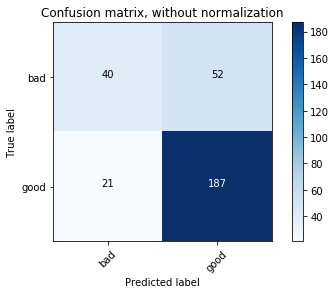

Normalized confusion matrix
[[0.43 0.57]
 [0.1  0.9 ]]


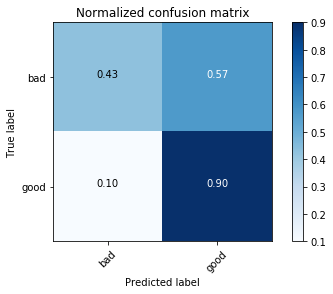

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 20:51:19 2018 with batch_size = 6 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 20:56:18 2018. Elapsed time (seconds) = 299.3616320415749

Compiling Training Results at: Sat May 12 20:56:18 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 20:56:20 2018. Elapsed time (seconds) = 1.507991884922376
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 20:56:20 2018

Best OOB Cohen's Kappa during tuning: 0.7571
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.7400
Cohen's Kappa on unseen instances: 0.3319

Precision: [0.61, 0.78]
Recall: [0.42, 0.88]
F1 Score: [0.5, 0.82]
Support: [92, 208]

Confusion matrix, without normalization
[[ 39  53]
 [ 25 183]]


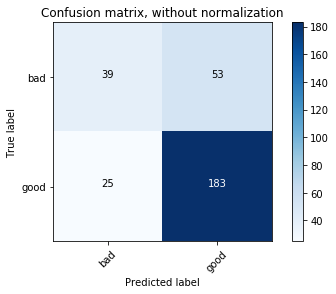

Normalized confusion matrix
[[0.42 0.58]
 [0.12 0.88]]


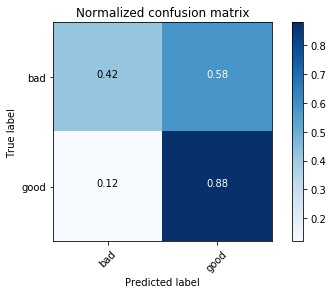

Working on Anchors for instance 80


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 103
Working on Anchors for instance 625
Working on Anchors for instance 860
Working on Anchors for instance 560
Working on Anchors for instance 280
Working on Anchors for instance 97
Working on Anchors for instance 267
Working on Anchors for instance 386
Working on Anchors for instance 787
Working on Anchors for instance 289
Working on Anchors for instance 249
Working on Anchors for instance 947
Working on Anchors for instance 439
Working on Anchors for instance 750
Working on Anchors for instance 359
Working on Anchors for instance 374
Working on Anchors for instance 299
Working on Anchors for instance 721
Working on Anchors for instance 319
Working on Anchors for instance 294
Working on Anchors for instance 76
Working on Anchors for instance 304
Working on Anchors for instance 985
Working on Anchors for instance 94
Working on Anchors for instance 314
Working on Anchors for instance 160
Working on Anchors for instance 513
Working on Anchors for instance

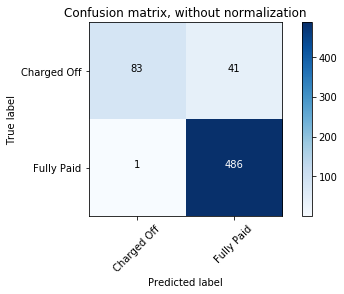

Normalized confusion matrix
[[0.67 0.33]
 [0.   1.  ]]


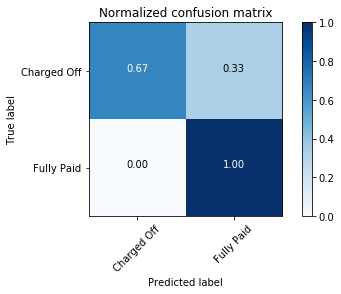

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 21:08:08 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 21:16:59 2018. Elapsed time (seconds) = 530.9779338282278

Compiling Training Results at: Sat May 12 21:16:59 2018...(please wait)
Results Completed at: Sat May 12 21:17:01 2018. Elapsed time (seconds) = 2.3099173528898973
Whiteboxing Randfor Done

Processing Anchors
Startin

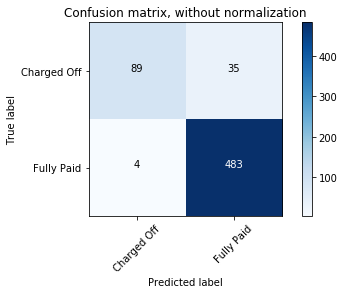

Normalized confusion matrix
[[0.72 0.28]
 [0.01 0.99]]


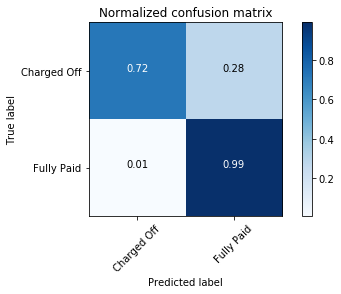

Working on Anchors for instance 859
Working on Anchors for instance 1978
Working on Anchors for instance 639
Working on Anchors for instance 599
Working on Anchors for instance 722
Working on Anchors for instance 778


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1145
Working on Anchors for instance 968
Working on Anchors for instance 1502
Working on Anchors for instance 889
Working on Anchors for instance 1576
Working on Anchors for instance 1903
Working on Anchors for instance 924
Working on Anchors for instance 264
Working on Anchors for instance 703
Working on Anchors for instance 1241
Working on Anchors for instance 331
Working on Anchors for instance 950
Working on Anchors for instance 1870
Working on Anchors for instance 673
Working on Anchors for instance 587
Working on Anchors for instance 243
Working on Anchors for instance 1203
Working on Anchors for instance 1826
Working on Anchors for instance 1169
Working on Anchors for instance 1347
Working on Anchors for instance 104
Working on Anchors for instance 1898
Working on Anchors for instance 1942
Working on Anchors for instance 494
Working on Anchors for instance 517
Working on Anchors for instance 1287
Working on Anchors for instance 963
Working on Anch

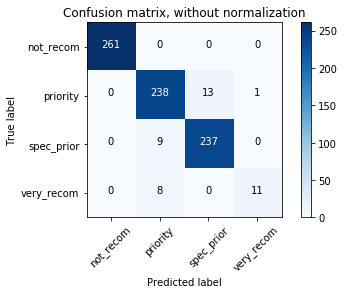

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.94 0.05 0.  ]
 [0.   0.04 0.96 0.  ]
 [0.   0.42 0.   0.58]]


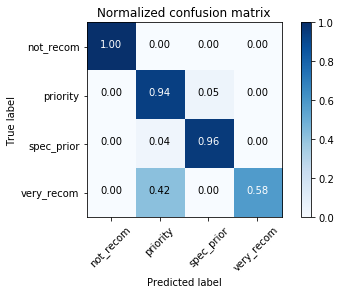

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 22:50:41 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 23:05:38 2

C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 23:05:39 2018. Elapsed time (seconds) = 1.1348852176852233
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 23:05:39 2018

Best OOB Cohen's Kappa during tuning: 0.9542
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9602
Cohen's Kappa on unseen instances: 0.9413

Precision: [1.0, 0.93, 0.95, 0.92]
Recall: [1.0, 0.94, 0.96, 0.58]
F1 Score: [1.0, 0.94, 0.96, 0.71]
Support: [261, 252, 246, 19]

Confusion matrix, without normalization
[[261   0   0   0]
 [  0 238  13   1]
 [  0   9 237   0]
 [  0   8   0  11]]


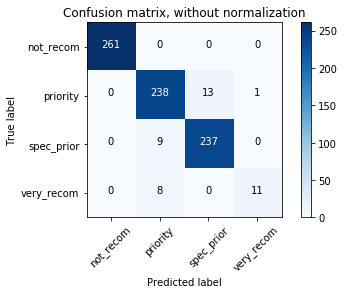

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.94 0.05 0.  ]
 [0.   0.04 0.96 0.  ]
 [0.   0.42 0.   0.58]]


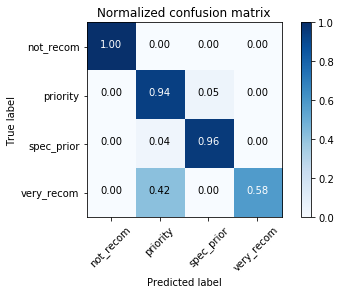

Working on Anchors for instance 375
Working on Anchors for instance 169
Working on Anchors for instance 2396
Working on Anchors for instance 1616
Working on Anchors for instance 1722
Working on Anchors for instance 1395
Working on Anchors for instance 42


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1271
Working on Anchors for instance 2376
Working on Anchors for instance 697
Working on Anchors for instance 2387
Working on Anchors for instance 1807
Working on Anchors for instance 974
Working on Anchors for instance 1396
Working on Anchors for instance 638
Working on Anchors for instance 248
Working on Anchors for instance 680
Working on Anchors for instance 301
Working on Anchors for instance 670
Working on Anchors for instance 2194
Working on Anchors for instance 1438
Working on Anchors for instance 104
Working on Anchors for instance 1755
Working on Anchors for instance 1364
Working on Anchors for instance 1802
Working on Anchors for instance 2269
Working on Anchors for instance 893
Working on Anchors for instance 2201
Working on Anchors for instance 159
Working on Anchors for instance 2508
Working on Anchors for instance 1955
Working on Anchors for instance 546
Working on Anchors for instance 1472
Working on Anchors for instance 1944
Working on A

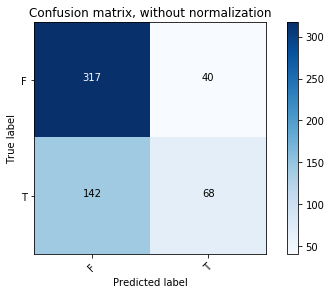

Normalized confusion matrix
[[0.89 0.11]
 [0.68 0.32]]


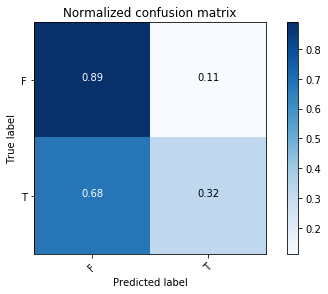

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 23:15:34 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 23:25:47 2018. Elapsed time (seconds) = 613.2855483836865

Compiling Training Results at: Sat May 12 23:25:47 2018...(please wait)
Results Completed at: Sat May 12 23:25:48 2018. Elapsed time (seconds) = 1.0708137252004235
Whiteboxing Randfor Done

Processing Anchors
Starting new run at:

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.6667
Cohen's Kappa on unseen instances: 0.1998

Precision: [0.68, 0.6]
Recall: [0.89, 0.29]
F1 Score: [0.77, 0.39]
Support: [357, 210]

Confusion matrix, without normalization
[[317  40]
 [149  61]]


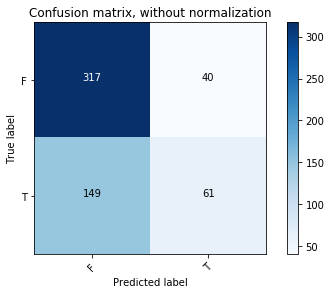

Normalized confusion matrix
[[0.89 0.11]
 [0.71 0.29]]


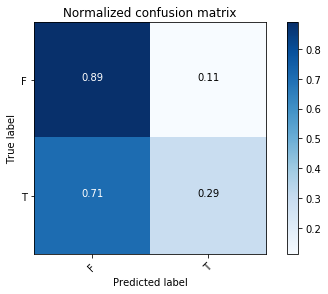

Working on Anchors for instance 357
Working on Anchors for instance 896
Working on Anchors for instance 503


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1170
Working on Anchors for instance 519
Working on Anchors for instance 455
Working on Anchors for instance 1383
Working on Anchors for instance 463
Working on Anchors for instance 502
Working on Anchors for instance 1173
Working on Anchors for instance 1353
Working on Anchors for instance 1571
Working on Anchors for instance 890
Working on Anchors for instance 653
Working on Anchors for instance 1756
Working on Anchors for instance 93
Working on Anchors for instance 1770
Working on Anchors for instance 401
Working on Anchors for instance 286
Working on Anchors for instance 1215
Working on Anchors for instance 200
Working on Anchors for instance 189
Working on Anchors for instance 212
Working on Anchors for instance 221
Working on Anchors for instance 376
Working on Anchors for instance 955
Working on Anchors for instance 834
Working on Anchors for instance 920
Working on Anchors for instance 1604
Working on Anchors for instance 701
Working on Anchors f

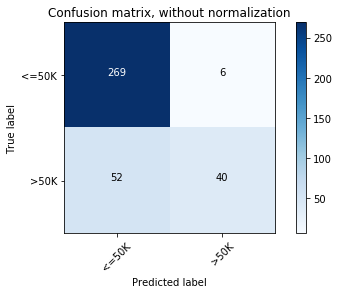

Normalized confusion matrix
[[0.98 0.02]
 [0.57 0.43]]


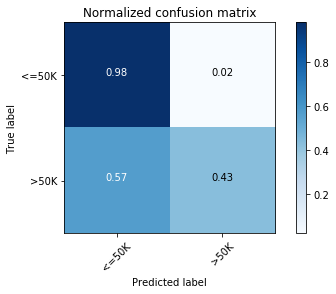

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 23:47:41 2018 with batch_size = 7 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sat May 12 23:50:59 2018. Elapsed time (seconds) = 198.11671853769803

Compiling Training Results at: Sat May 12 23:50:59 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sat May 12 23:51:00 2018. Elapsed time (seconds) = 1.099842073286709
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sat May 12 23:51:00 2018

Best OOB Cohen's Kappa during tuning: 0.8384
Best parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.8229
Cohen's Kappa on unseen instances: 0.4511

Precision: [0.83, 0.75]
Recall: [0.95, 0.43]
F1 Score: [0.89, 0.55]
Support: [275, 92]

Confusion matrix, without normalization
[[262  13]
 [ 52  40]]


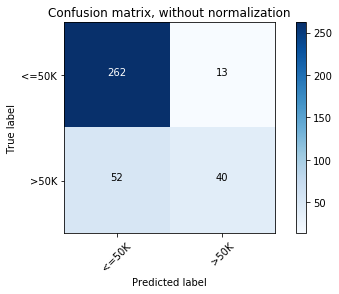

Normalized confusion matrix
[[0.95 0.05]
 [0.57 0.43]]


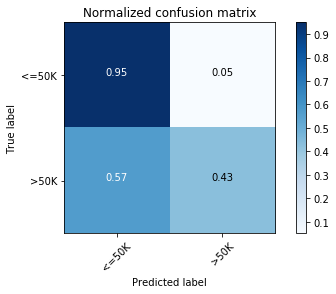

Working on Anchors for instance 1189
Working on Anchors for instance 703
Working on Anchors for instance 798
Working on Anchors for instance 842
Working on Anchors for instance 488
Working on Anchors for instance 1
Working on Anchors for instance 839
Working on Anchors for instance 787
Working on Anchors for instance 538
Working on Anchors for instance 607
Working on Anchors for instance 466
Working on Anchors for instance 747
Working on Anchors for instance 415


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 170
Working on Anchors for instance 857
Working on Anchors for instance 181
Working on Anchors for instance 406
Working on Anchors for instance 1036
Working on Anchors for instance 585
Working on Anchors for instance 300
Working on Anchors for instance 139
Working on Anchors for instance 37
Working on Anchors for instance 616
Working on Anchors for instance 980
Working on Anchors for instance 946
Working on Anchors for instance 394
Working on Anchors for instance 988
Working on Anchors for instance 250
Working on Anchors for instance 509
Working on Anchors for instance 511
Working on Anchors for instance 691
Working on Anchors for instance 610
Working on Anchors for instance 371
Working on Anchors for instance 1164
Working on Anchors for instance 338
Anchors Done. Completed run at: Sat May 12 23:58:11 2018. Elapsed time (seconds) = 430.74005851941547

Results saved at whiteboxing\adult_small_samp_pickles\results.pickle

To retrieve results execute the fo

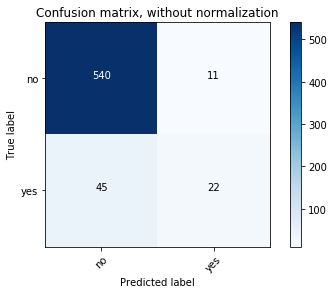

Normalized confusion matrix
[[0.98 0.02]
 [0.67 0.33]]


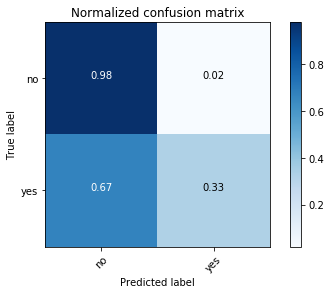

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sat May 12 23:58:44 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 00:11:31 2018. Elapsed time (seconds) = 766.6898687129069

Compiling Training Results at: Sun May 13 00:11:31 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sun May 13 00:11:33 2018. Elapsed time (seconds) = 1.990858218705398
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 00:11:33 2018

Best OOB Cohen's Kappa during tuning: 0.9195
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 1500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9029
Cohen's Kappa on unseen instances: 0.3312

Precision: [0.92, 0.62]
Recall: [0.98, 0.27]
F1 Score: [0.95, 0.38]
Support: [551, 67]

Confusion matrix, without normalization
[[540  11]
 [ 49  18]]


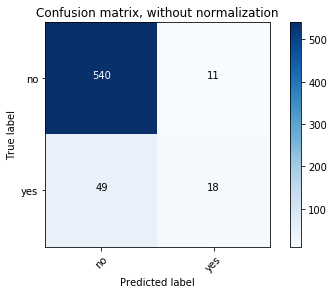

Normalized confusion matrix
[[0.98 0.02]
 [0.73 0.27]]


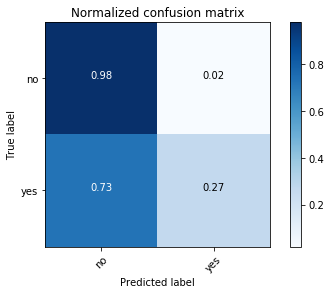

Working on Anchors for instance 1329
Working on Anchors for instance 648
Working on Anchors for instance 686


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 370
Working on Anchors for instance 710
Working on Anchors for instance 26
Working on Anchors for instance 1549
Working on Anchors for instance 468
Working on Anchors for instance 211
Working on Anchors for instance 665
Working on Anchors for instance 1996
Working on Anchors for instance 898
Working on Anchors for instance 1850
Working on Anchors for instance 1026
Working on Anchors for instance 865
Working on Anchors for instance 1603
Working on Anchors for instance 486
Working on Anchors for instance 1731
Working on Anchors for instance 68
Working on Anchors for instance 1816
Working on Anchors for instance 583
Working on Anchors for instance 789
Working on Anchors for instance 1852
Working on Anchors for instance 1961
Working on Anchors for instance 1454
Working on Anchors for instance 17
Working on Anchors for instance 1709
Working on Anchors for instance 431
Working on Anchors for instance 799
Working on Anchors for instance 333
Working on Anchors f

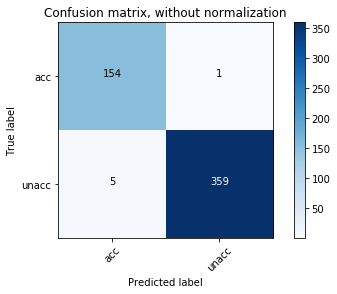

Normalized confusion matrix
[[0.99 0.01]
 [0.01 0.99]]


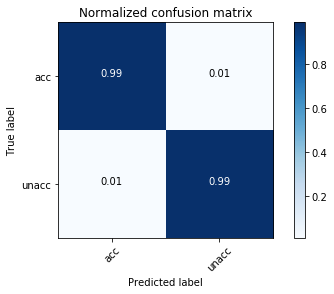

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 00:31:19 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 00:41:58 2

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9884
Cohen's Kappa on unseen instances: 0.9726

Precision: [0.97, 1.0]
Recall: [0.99, 0.99]
F1 Score: [0.98, 0.99]
Support: [155, 364]

Confusion matrix, without normalization
[[154   1]
 [  5 359]]


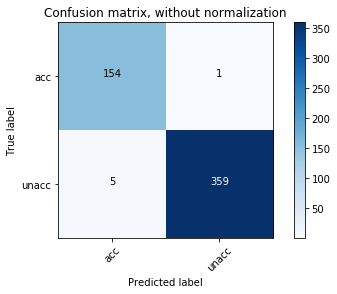

Normalized confusion matrix
[[0.99 0.01]
 [0.01 0.99]]


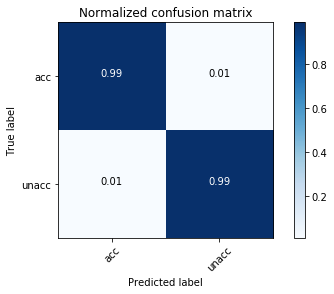

Working on Anchors for instance 1124
Working on Anchors for instance 438
Working on Anchors for instance 1699
Working on Anchors for instance 805


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 398
Working on Anchors for instance 1326
Working on Anchors for instance 1238
Working on Anchors for instance 502
Working on Anchors for instance 10
Working on Anchors for instance 205
Working on Anchors for instance 445
Working on Anchors for instance 1249
Working on Anchors for instance 597
Working on Anchors for instance 654
Working on Anchors for instance 1167
Working on Anchors for instance 1465
Working on Anchors for instance 1360
Working on Anchors for instance 365
Working on Anchors for instance 388
Working on Anchors for instance 1320
Working on Anchors for instance 1056
Working on Anchors for instance 1514
Working on Anchors for instance 1490
Working on Anchors for instance 713
Working on Anchors for instance 509
Working on Anchors for instance 714
Working on Anchors for instance 1206
Working on Anchors for instance 1171
Working on Anchors for instance 1451
Working on Anchors for instance 75
Working on Anchors for instance 1436
Working on Ancho

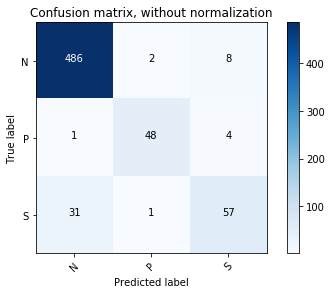

Normalized confusion matrix
[[0.98 0.   0.02]
 [0.02 0.91 0.08]
 [0.35 0.01 0.64]]


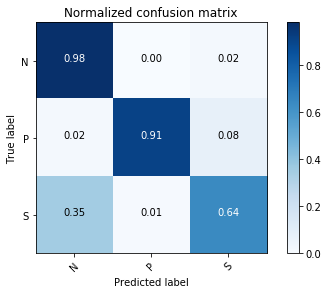

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 00:53:31 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 01:06:02 2018. Elapsed time (seconds) = 751.6024756875195

Compiling Training Results at: Sun May 13 01:06:02 2018...(please wait)
Results Completed at: Sun May 13 01:06:04 2018. Elapsed time (seconds) = 1.187298497716256
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 01:06:04 2018



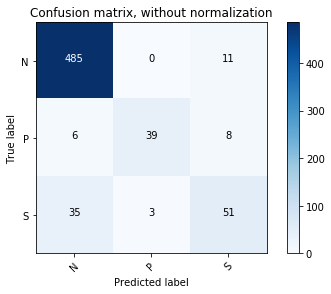

Normalized confusion matrix
[[0.98 0.   0.02]
 [0.11 0.74 0.15]
 [0.39 0.03 0.57]]


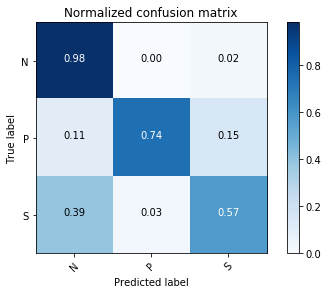

Working on Anchors for instance 1937
Working on Anchors for instance 765
Working on Anchors for instance 134
Working on Anchors for instance 1582


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1014
Working on Anchors for instance 1106
Working on Anchors for instance 1631
Working on Anchors for instance 1654
Working on Anchors for instance 1239
Working on Anchors for instance 706
Working on Anchors for instance 1083
Working on Anchors for instance 1458
Working on Anchors for instance 1431
Working on Anchors for instance 193
Working on Anchors for instance 2107
Working on Anchors for instance 1844
Working on Anchors for instance 1292
Working on Anchors for instance 1525
Working on Anchors for instance 950
Working on Anchors for instance 1519
Working on Anchors for instance 1987
Working on Anchors for instance 1441
Working on Anchors for instance 403
Working on Anchors for instance 1156
Working on Anchors for instance 163
Working on Anchors for instance 1923
Working on Anchors for instance 1036
Working on Anchors for instance 59
Working on Anchors for instance 722
Working on Anchors for instance 1526
Working on Anchors for instance 2001
Working o

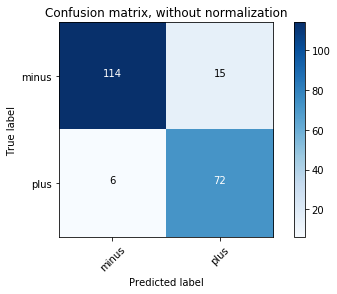

Normalized confusion matrix
[[0.88 0.12]
 [0.08 0.92]]


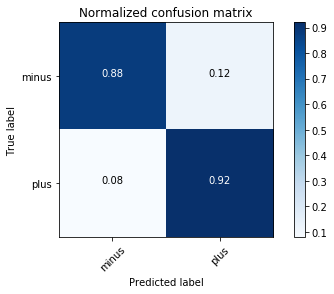

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 02:08:31 2018 with batch_size = 4 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 02:10:09 2018. Elapsed time (seconds) = 97.69419366934744

Compiling Training Results at: Sun May 13 02:10:09 2018...(please wait)
Results Completed at: Sun May 13 02:10:10 2018. Elapsed time (seconds) = 0.5571174288488692
Whiteboxing Randfor Done

Processing Anchors
Startin

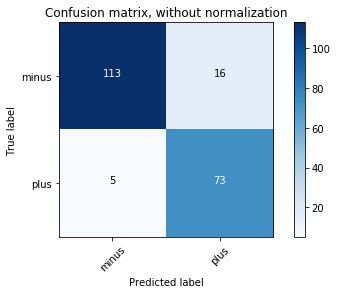

Normalized confusion matrix
[[0.88 0.12]
 [0.06 0.94]]


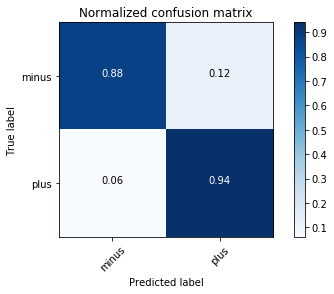

Working on Anchors for instance 232
Working on Anchors for instance 573
Working on Anchors for instance 554
Working on Anchors for instance 669
Working on Anchors for instance 310
Working on Anchors for instance 508
Working on Anchors for instance 209
Working on Anchors for instance 201
Working on Anchors for instance 397
Working on Anchors for instance 672
Working on Anchors for instance 334
Working on Anchors for instance 429
Working on Anchors for instance 516
Working on Anchors for instance 631
Working on Anchors for instance 314
Working on Anchors for instance 479
Working on Anchors for instance 447
Working on Anchors for instance 324
Working on Anchors for instance 3
Working on Anchors for instance 250
Anchors Done. Completed run at: Sun May 13 02:12:52 2018. Elapsed time (seconds) = 162.02222692289797

Results saved at whiteboxing\credit_pickles\results.pickle

To retrieve results execute the following:
results_store = open('whiteboxing\credit_pickles\results.pickle', "rb")
resu

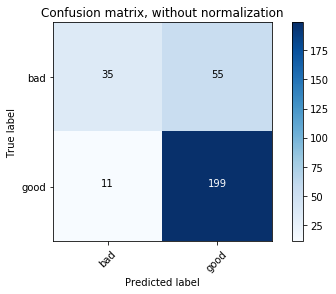

Normalized confusion matrix
[[0.39 0.61]
 [0.05 0.95]]


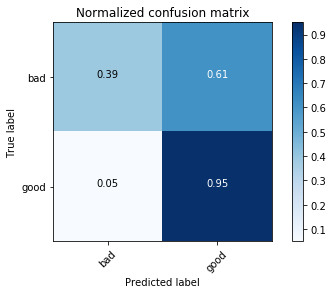

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 02:13:17 2018 with batch_size = 6 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 02:21:18 2018. Elapsed time (seconds) = 481.5114725223757

Compiling Training Results at: Sun May 13 02:21:18 2018...(please wait)
Results Completed at: Sun May 13 02:21:20 2018. Elapsed time (seconds) = 1.6473012139540515
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 02:21:20 2018

Best OOB Cohen's Kappa during tuning: 0.7671
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 1500}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.7500
Cohen's Kappa on unseen instances: 0.3107

Precision: [0.66, 0.77]
Recall: [0.34, 0.92]
F1 Score: [0.45, 0.84]
Support: [90, 210]

Confusion matrix, without normalization
[[ 31  59]
 [ 16 194]]


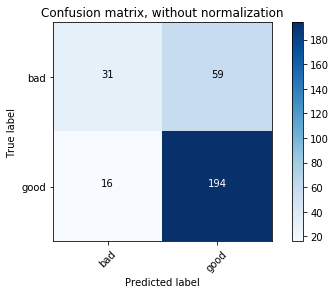

Normalized confusion matrix
[[0.34 0.66]
 [0.08 0.92]]


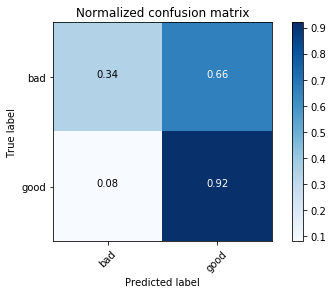

Working on Anchors for instance 441
Working on Anchors for instance 8
Working on Anchors for instance 873
Working on Anchors for instance 887


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 426
Working on Anchors for instance 232
Working on Anchors for instance 990
Working on Anchors for instance 420
Working on Anchors for instance 194
Working on Anchors for instance 844
Working on Anchors for instance 336
Working on Anchors for instance 18
Working on Anchors for instance 415
Working on Anchors for instance 109
Working on Anchors for instance 892
Working on Anchors for instance 164
Working on Anchors for instance 659
Working on Anchors for instance 678
Working on Anchors for instance 83
Working on Anchors for instance 462
Working on Anchors for instance 864
Working on Anchors for instance 514
Working on Anchors for instance 900
Working on Anchors for instance 287
Working on Anchors for instance 163
Working on Anchors for instance 319
Working on Anchors for instance 933
Working on Anchors for instance 330
Working on Anchors for instance 894
Working on Anchors for instance 849
Anchors Done. Completed run at: Sun May 13 02:39:36 2018. Elapsed 

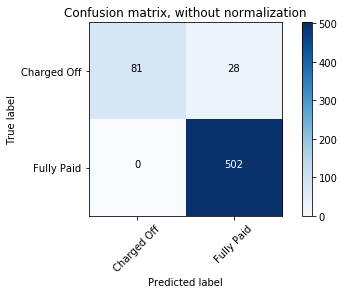

Normalized confusion matrix
[[0.74 0.26]
 [0.   1.  ]]


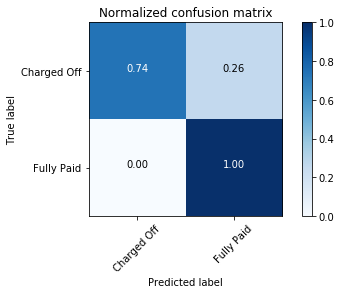

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 02:40:26 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 02:53:02 2018. Elapsed time (seconds) = 756.0674685994454

Compiling Training Results at: Sun May 13 02:53:02 2018...(please wait)
Results Completed at: Sun May 13 02:53:05 2018. Elapsed time (seconds) = 2.4767731149622705
Whiteboxing Randfor Done

Processing Anchors
Startin

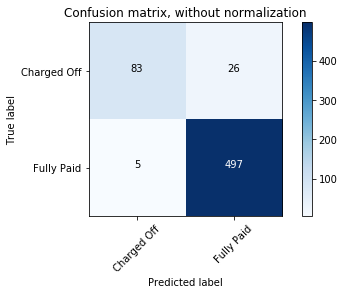

Normalized confusion matrix
[[0.76 0.24]
 [0.01 0.99]]


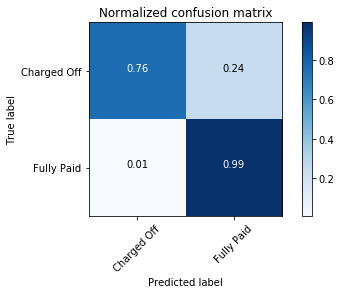

Working on Anchors for instance 679


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1767
Working on Anchors for instance 131
Working on Anchors for instance 2010
Working on Anchors for instance 94
Working on Anchors for instance 536
Working on Anchors for instance 910
Working on Anchors for instance 57
Working on Anchors for instance 338
Working on Anchors for instance 613
Working on Anchors for instance 683
Working on Anchors for instance 637
Working on Anchors for instance 1073
Working on Anchors for instance 414
Working on Anchors for instance 1965
Working on Anchors for instance 608
Working on Anchors for instance 59
Working on Anchors for instance 648
Working on Anchors for instance 1025
Working on Anchors for instance 407
Working on Anchors for instance 593
Working on Anchors for instance 1064
Working on Anchors for instance 715
Working on Anchors for instance 1009
Working on Anchors for instance 808
Working on Anchors for instance 668
Working on Anchors for instance 403
Working on Anchors for instance 1202
Working on Anchors for 

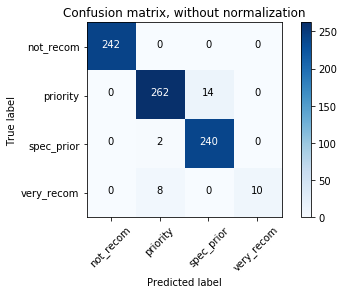

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.95 0.05 0.  ]
 [0.   0.01 0.99 0.  ]
 [0.   0.44 0.   0.56]]


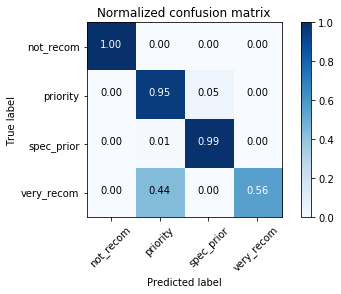

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 04:55:34 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 05:13:35 2018. Elapsed time (seconds) = 1081.2105710541

Compiling Training Results at: Sun May 13 05:13:35 2018...(please wait)
Results Completed at: Sun May 13 05:13:36 2018. Elapsed time (seconds) = 1.292318560052081
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 05:13:36 2018

Best OOB Cohen's Kappa during tuning: 0.9559
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 1000}

Training a random forest model using best parameter

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9692
Cohen's Kappa on unseen instances: 0.9545

Precision: [1.0, 0.96, 0.94, 1.0]
Recall: [1.0, 0.95, 0.99, 0.56]
F1 Score: [1.0, 0.96, 0.97, 0.71]
Support: [242, 276, 242, 18]

Confusion matrix, without normalization
[[242   0   0   0]
 [  0 262  14   0]
 [  0   2 240   0]
 [  0   8   0  10]]


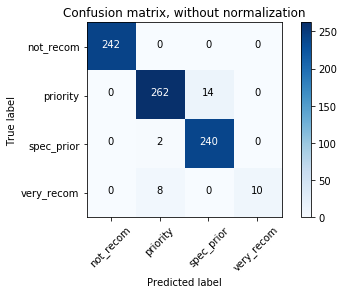

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.95 0.05 0.  ]
 [0.   0.01 0.99 0.  ]
 [0.   0.44 0.   0.56]]


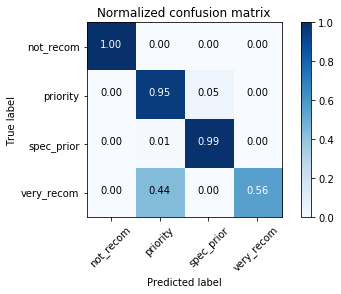

Working on Anchors for instance 2192


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 263
Working on Anchors for instance 2113
Working on Anchors for instance 149
Working on Anchors for instance 431
Working on Anchors for instance 897
Working on Anchors for instance 1626
Working on Anchors for instance 2382
Working on Anchors for instance 1531
Working on Anchors for instance 1089
Working on Anchors for instance 2477
Working on Anchors for instance 889
Working on Anchors for instance 1461
Working on Anchors for instance 1974
Working on Anchors for instance 1647
Working on Anchors for instance 2221
Working on Anchors for instance 794
Working on Anchors for instance 471
Working on Anchors for instance 2464
Working on Anchors for instance 2139
Working on Anchors for instance 2054
Working on Anchors for instance 971
Working on Anchors for instance 1621
Working on Anchors for instance 1382
Working on Anchors for instance 1375
Working on Anchors for instance 2182
Working on Anchors for instance 2580
Working on Anchors for instance 2099
Working o

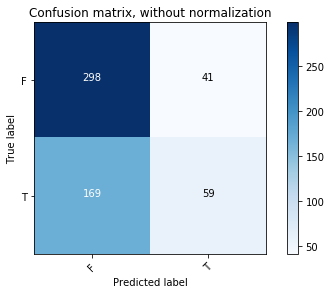

Normalized confusion matrix
[[0.88 0.12]
 [0.74 0.26]]


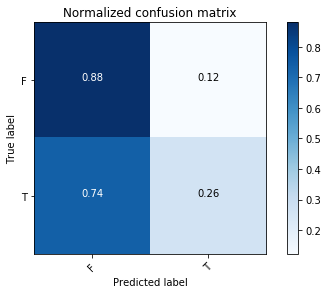

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 05:31:07 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 05:41:33 2018. Elapsed time (seconds) = 625.3328218342722

Compiling Training Results at: Sun May 13 05:41:33 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sun May 13 05:41:34 2018. Elapsed time (seconds) = 1.0692158289675717
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 05:41:34 2018

Best OOB Cohen's Kappa during tuning: 0.6654
Best parameters: {'max_depth': 16, 'min_samples_leaf': 5, 'n_estimators': 1000}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.6243
Cohen's Kappa on unseen instances: 0.1265

Precision: [0.63, 0.59]
Recall: [0.9, 0.21]
F1 Score: [0.74, 0.31]
Support: [339, 228]

Confusion matrix, without normalization
[[306  33]
 [180  48]]


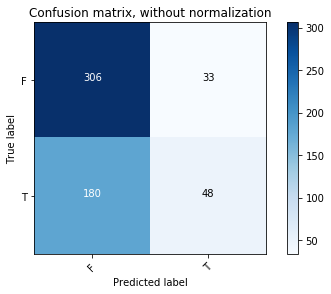

Normalized confusion matrix
[[0.9  0.1 ]
 [0.79 0.21]]


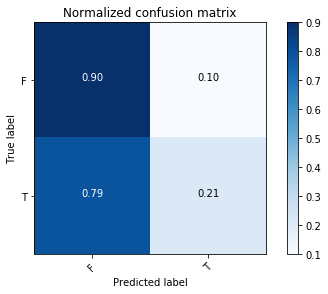

Working on Anchors for instance 522
Working on Anchors for instance 62
Working on Anchors for instance 1751
Working on Anchors for instance 1780
Working on Anchors for instance 142
Working on Anchors for instance 263
Working on Anchors for instance 163
Working on Anchors for instance 1163
Working on Anchors for instance 429
Working on Anchors for instance 120
Working on Anchors for instance 744
Working on Anchors for instance 990


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1261
Working on Anchors for instance 1053
Working on Anchors for instance 762
Working on Anchors for instance 810
Working on Anchors for instance 1612
Working on Anchors for instance 935
Working on Anchors for instance 1284
Working on Anchors for instance 581
Working on Anchors for instance 1687
Working on Anchors for instance 869
Working on Anchors for instance 241
Working on Anchors for instance 886
Working on Anchors for instance 1164
Working on Anchors for instance 1291
Working on Anchors for instance 676
Working on Anchors for instance 694
Working on Anchors for instance 1340
Working on Anchors for instance 511
Working on Anchors for instance 902
Working on Anchors for instance 682
Working on Anchors for instance 458
Working on Anchors for instance 1877
Working on Anchors for instance 1827
Working on Anchors for instance 1652
Working on Anchors for instance 435
Working on Anchors for instance 613
Working on Anchors for instance 542
Working on Anchor

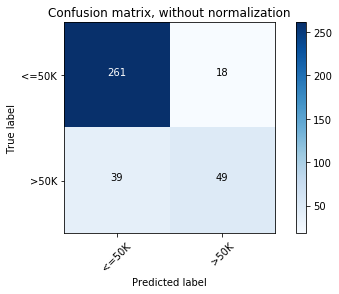

Normalized confusion matrix
[[0.94 0.06]
 [0.44 0.56]]


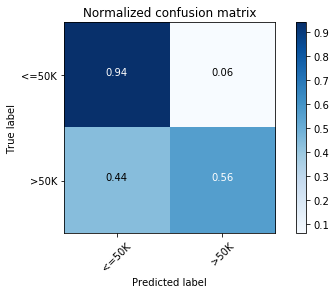

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 05:59:22 2018 with batch_size = 7 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 06:05:38 2018. Elapsed time (seconds) = 376.09829645873106

Compiling Training Results at: Sun May 13 06:05:38 2018...(please wait)
Results Completed at: Sun May 13 06:05:40 2018. Elapsed time (seconds) = 1.211308405996533
Whiteboxing Randfor Done

Processing Anchors
Startin

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.8174
Cohen's Kappa on unseen instances: 0.4726

Precision: [0.86, 0.64]
Recall: [0.9, 0.55]
F1 Score: [0.88, 0.59]
Support: [279, 88]

Confusion matrix, without normalization
[[252  27]
 [ 40  48]]


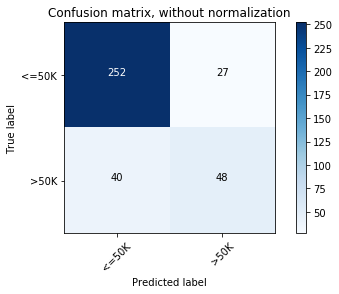

Normalized confusion matrix
[[0.9  0.1 ]
 [0.45 0.55]]


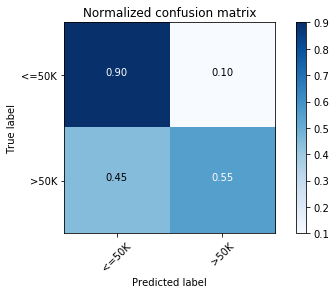

Working on Anchors for instance 1053
Working on Anchors for instance 57


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 666
Working on Anchors for instance 475
Working on Anchors for instance 833
Working on Anchors for instance 1091
Working on Anchors for instance 285
Working on Anchors for instance 1121
Working on Anchors for instance 116
Working on Anchors for instance 1174
Working on Anchors for instance 277
Working on Anchors for instance 397
Working on Anchors for instance 112
Working on Anchors for instance 598
Working on Anchors for instance 1173
Working on Anchors for instance 645
Working on Anchors for instance 474
Working on Anchors for instance 622
Working on Anchors for instance 478
Working on Anchors for instance 1030
Working on Anchors for instance 731
Working on Anchors for instance 155
Working on Anchors for instance 320
Working on Anchors for instance 533
Working on Anchors for instance 532
Working on Anchors for instance 403
Working on Anchors for instance 925
Working on Anchors for instance 1095
Working on Anchors for instance 842
Working on Anchors for

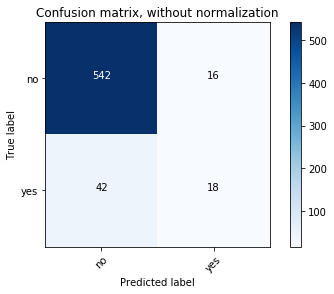

Normalized confusion matrix
[[0.97 0.03]
 [0.7  0.3 ]]


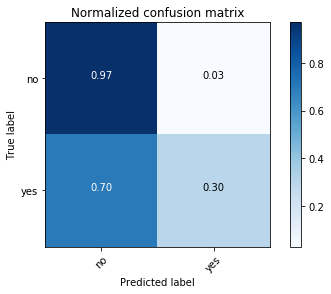

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 06:22:11 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 06:29:03 2018. Elapsed time (seconds) = 411.9794517995979

Compiling Training Results at: Sun May 13 06:29:03 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sun May 13 06:29:05 2018. Elapsed time (seconds) = 1.83637248109153
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 06:29:05 2018

Best OOB Cohen's Kappa during tuning: 0.9209
Best parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 1000}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9110
Cohen's Kappa on unseen instances: 0.3528

Precision: [0.93, 0.58]
Recall: [0.98, 0.3]
F1 Score: [0.95, 0.4]
Support: [558, 60]

Confusion matrix, without normalization
[[545  13]
 [ 42  18]]


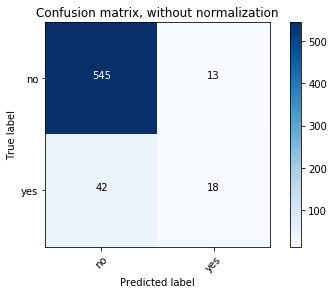

Normalized confusion matrix
[[0.98 0.02]
 [0.7  0.3 ]]


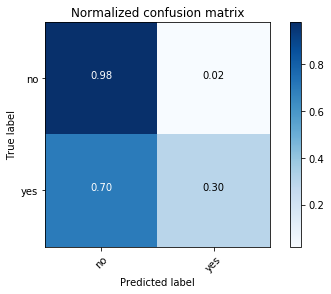

Working on Anchors for instance 134
Working on Anchors for instance 958
Working on Anchors for instance 185


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 87
Working on Anchors for instance 940
Working on Anchors for instance 1775
Working on Anchors for instance 10
Working on Anchors for instance 619
Working on Anchors for instance 932
Working on Anchors for instance 461
Working on Anchors for instance 744
Working on Anchors for instance 1912
Working on Anchors for instance 804
Working on Anchors for instance 638
Working on Anchors for instance 1976
Working on Anchors for instance 1563
Working on Anchors for instance 2049
Working on Anchors for instance 1361
Working on Anchors for instance 1572
Working on Anchors for instance 258
Working on Anchors for instance 99
Working on Anchors for instance 754
Working on Anchors for instance 1351
Working on Anchors for instance 901
Working on Anchors for instance 700
Working on Anchors for instance 1202
Working on Anchors for instance 2014
Working on Anchors for instance 1545
Working on Anchors for instance 971
Working on Anchors for instance 646
Working on Anchors f

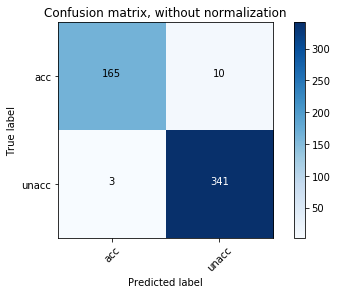

Normalized confusion matrix
[[0.94 0.06]
 [0.01 0.99]]


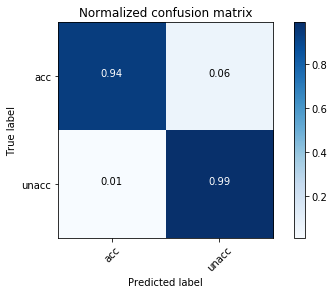

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 06:44:58 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 06:53:50 2

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9750
Cohen's Kappa on unseen instances: 0.9434

Precision: [0.98, 0.97]
Recall: [0.94, 0.99]
F1 Score: [0.96, 0.98]
Support: [175, 344]

Confusion matrix, without normalization
[[165  10]
 [  3 341]]


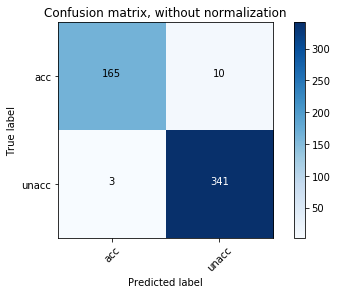

Normalized confusion matrix
[[0.94 0.06]
 [0.01 0.99]]


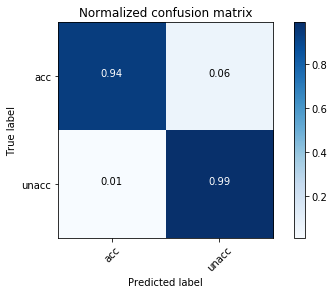

Working on Anchors for instance 1257
Working on Anchors for instance 1270
Working on Anchors for instance 327
Working on Anchors for instance 1630
Working on Anchors for instance 375
Working on Anchors for instance 1722


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1078
Working on Anchors for instance 958
Working on Anchors for instance 1571
Working on Anchors for instance 1325
Working on Anchors for instance 864
Working on Anchors for instance 1388
Working on Anchors for instance 1273
Working on Anchors for instance 770
Working on Anchors for instance 818
Working on Anchors for instance 811
Working on Anchors for instance 699
Working on Anchors for instance 1677
Working on Anchors for instance 1605
Working on Anchors for instance 1138
Working on Anchors for instance 1667
Working on Anchors for instance 567
Working on Anchors for instance 570
Working on Anchors for instance 1411
Working on Anchors for instance 56
Working on Anchors for instance 551
Working on Anchors for instance 1521
Working on Anchors for instance 1711
Working on Anchors for instance 991
Working on Anchors for instance 394
Working on Anchors for instance 312
Working on Anchors for instance 828
Working on Anchors for instance 1215
Working on Ancho

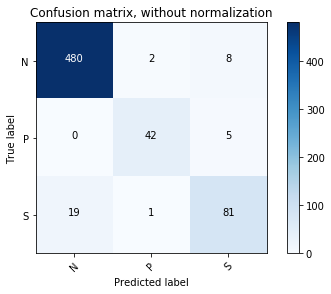

Normalized confusion matrix
[[0.98 0.   0.02]
 [0.   0.89 0.11]
 [0.19 0.01 0.8 ]]


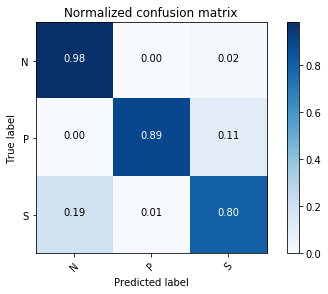

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 07:00:32 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 07:06:25 2018. Elapsed time (seconds) = 353.3887908690958

Compiling Training Results at: Sun May 13 07:06:25 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sun May 13 07:06:27 2018. Elapsed time (seconds) = 1.0811213277338538
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 07:06:27 2018

Best OOB Cohen's Kappa during tuning: 0.9429
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9122
Cohen's Kappa on unseen instances: 0.7558

Precision: [0.94, 0.87, 0.78]
Recall: [0.98, 0.72, 0.68]
F1 Score: [0.96, 0.79, 0.73]
Support: [490, 47, 101]

Confusion matrix, without normalization
[[479   0  11]
 [  4  34   9]
 [ 27   5  69]]


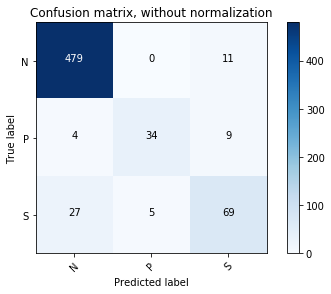

Normalized confusion matrix
[[0.98 0.   0.02]
 [0.09 0.72 0.19]
 [0.27 0.05 0.68]]


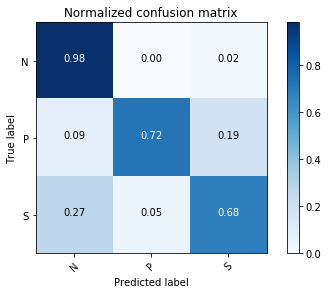

Working on Anchors for instance 112
Working on Anchors for instance 1123
Working on Anchors for instance 1022
Working on Anchors for instance 956


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 15
Working on Anchors for instance 1011
Working on Anchors for instance 1936
Working on Anchors for instance 847
Working on Anchors for instance 1039
Working on Anchors for instance 1915
Working on Anchors for instance 1339
Working on Anchors for instance 1926
Working on Anchors for instance 534
Working on Anchors for instance 1399
Working on Anchors for instance 1235
Working on Anchors for instance 405
Working on Anchors for instance 551
Working on Anchors for instance 1259
Working on Anchors for instance 1444
Working on Anchors for instance 1776
Working on Anchors for instance 1441
Working on Anchors for instance 885
Working on Anchors for instance 2066
Working on Anchors for instance 638
Working on Anchors for instance 370
Working on Anchors for instance 2117
Working on Anchors for instance 1309
Working on Anchors for instance 360
Working on Anchors for instance 1356
Working on Anchors for instance 758
Working on Anchors for instance 1747
Working on A

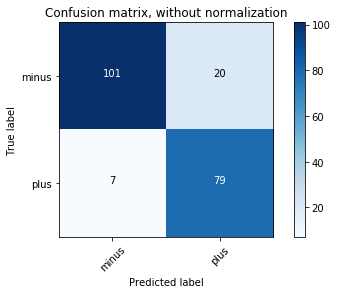

Normalized confusion matrix
[[0.83 0.17]
 [0.08 0.92]]


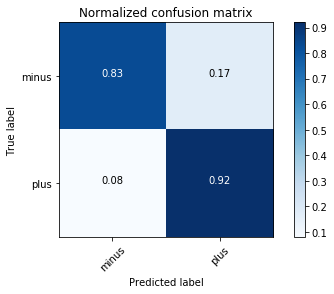

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 07:31:06 2018 with batch_size = 4 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 07:34:35 2018. Elapsed time (seconds) = 208.8418707705132

Compiling Training Results at: Sun May 13 07:34:35 2018...(please wait)
Results Completed at: Sun May 13 07:34:36 2018. Elapsed time (seconds) = 0.6092278357318719
Whiteboxing Randfor Done

Processing Anchors
Starting new run at:

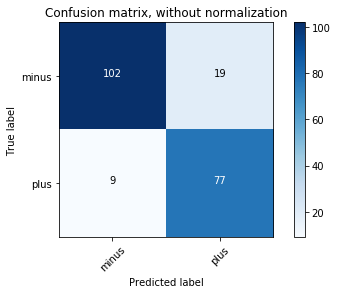

Normalized confusion matrix
[[0.84 0.16]
 [0.1  0.9 ]]


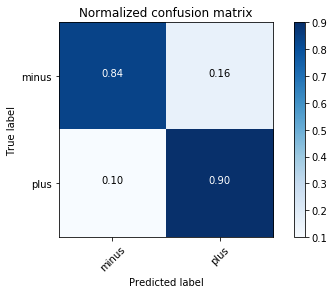

Working on Anchors for instance 662
Working on Anchors for instance 519
Working on Anchors for instance 45
Working on Anchors for instance 160
Working on Anchors for instance 258
Working on Anchors for instance 621
Working on Anchors for instance 375
Working on Anchors for instance 448
Working on Anchors for instance 20
Working on Anchors for instance 383
Working on Anchors for instance 194
Working on Anchors for instance 208
Working on Anchors for instance 616
Working on Anchors for instance 270
Working on Anchors for instance 67
Working on Anchors for instance 411
Working on Anchors for instance 54
Working on Anchors for instance 264
Working on Anchors for instance 36
Working on Anchors for instance 441
Anchors Done. Completed run at: Sun May 13 07:43:04 2018. Elapsed time (seconds) = 508.5065886928569

Results saved at whiteboxing\credit_pickles\results.pickle

To retrieve results execute the following:
results_store = open('whiteboxing\credit_pickles\results.pickle', "rb")
results 

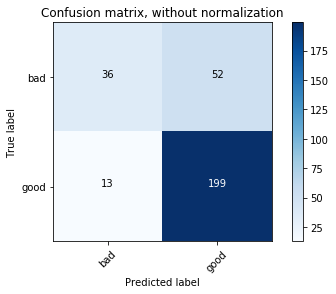

Normalized confusion matrix
[[0.41 0.59]
 [0.06 0.94]]


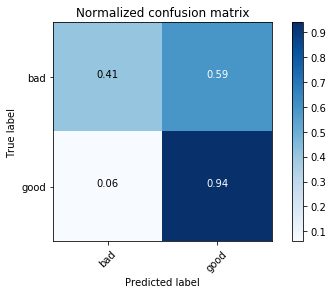

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 07:43:27 2018 with batch_size = 6 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 07:48:38 2018. Elapsed time (seconds) = 310.63481580925145

Compiling Training Results at: Sun May 13 07:48:38 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sun May 13 07:48:39 2018. Elapsed time (seconds) = 1.4754807960998733
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 07:48:39 2018

Best OOB Cohen's Kappa during tuning: 0.7629
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.7733
Cohen's Kappa on unseen instances: 0.3742

Precision: [0.7, 0.79]
Recall: [0.4, 0.93]
F1 Score: [0.51, 0.85]
Support: [88, 212]

Confusion matrix, without normalization
[[ 35  53]
 [ 15 197]]


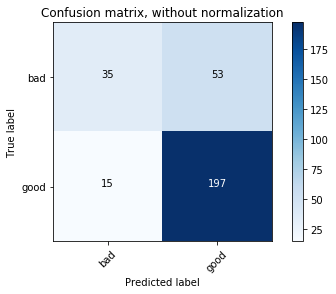

Normalized confusion matrix
[[0.4  0.6 ]
 [0.07 0.93]]


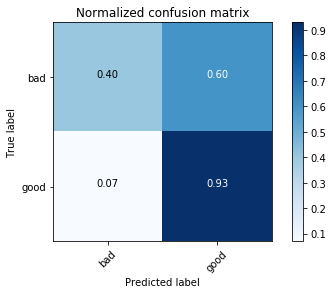

Working on Anchors for instance 659


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 506
Working on Anchors for instance 927
Working on Anchors for instance 577
Working on Anchors for instance 81
Working on Anchors for instance 856
Working on Anchors for instance 331
Working on Anchors for instance 558
Working on Anchors for instance 25
Working on Anchors for instance 159
Working on Anchors for instance 639
Working on Anchors for instance 400
Working on Anchors for instance 320
Working on Anchors for instance 988
Working on Anchors for instance 540
Working on Anchors for instance 241
Working on Anchors for instance 454
Working on Anchors for instance 680
Working on Anchors for instance 801
Working on Anchors for instance 687
Working on Anchors for instance 387
Working on Anchors for instance 914
Working on Anchors for instance 380
Working on Anchors for instance 225
Working on Anchors for instance 776
Working on Anchors for instance 493
Working on Anchors for instance 668
Working on Anchors for instance 913
Working on Anchors for instanc

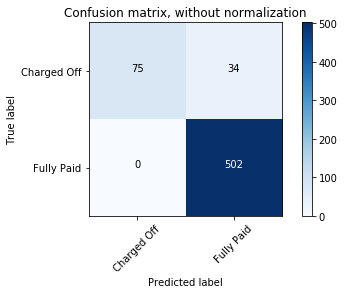

Normalized confusion matrix
[[0.69 0.31]
 [0.   1.  ]]


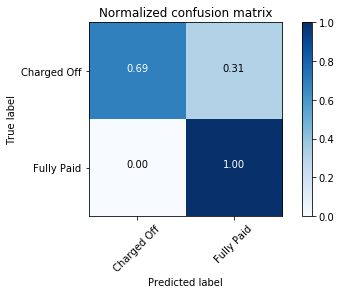

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 07:56:45 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 08:09:39 2018. Elapsed time (seconds) = 773.5255756542902

Compiling Training Results at: Sun May 13 08:09:39 2018...(please wait)
Results Completed at: Sun May 13 08:09:41 2018. Elapsed time (seconds) = 2.562930309730291
Whiteboxing Randfor Done

Processing Anchors
Starting

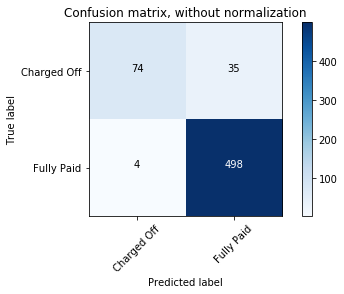

Normalized confusion matrix
[[0.68 0.32]
 [0.01 0.99]]


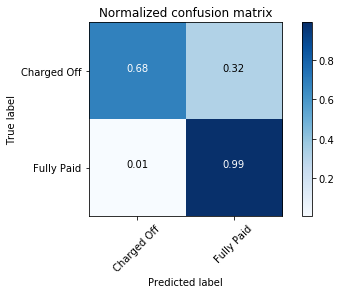

Working on Anchors for instance 664
Working on Anchors for instance 1682
Working on Anchors for instance 1283
Working on Anchors for instance 206
Working on Anchors for instance 1038
Working on Anchors for instance 1680
Working on Anchors for instance 1354
Working on Anchors for instance 1603
Working on Anchors for instance 682
Working on Anchors for instance 413


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1077
Working on Anchors for instance 1467
Working on Anchors for instance 1678
Working on Anchors for instance 1481
Working on Anchors for instance 1351
Working on Anchors for instance 1277
Working on Anchors for instance 354
Working on Anchors for instance 939
Working on Anchors for instance 1185
Working on Anchors for instance 1737
Working on Anchors for instance 1314
Working on Anchors for instance 1835
Working on Anchors for instance 1695
Working on Anchors for instance 286
Working on Anchors for instance 1287
Working on Anchors for instance 1399
Working on Anchors for instance 1973
Working on Anchors for instance 1945
Working on Anchors for instance 1179
Working on Anchors for instance 1213
Working on Anchors for instance 1404
Working on Anchors for instance 1823
Working on Anchors for instance 329
Working on Anchors for instance 620
Working on Anchors for instance 406
Working on Anchors for instance 296
Working on Anchors for instance 1825
Working 

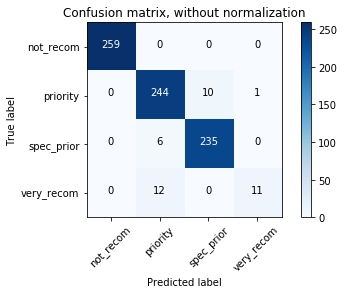

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.96 0.04 0.  ]
 [0.   0.02 0.98 0.  ]
 [0.   0.52 0.   0.48]]


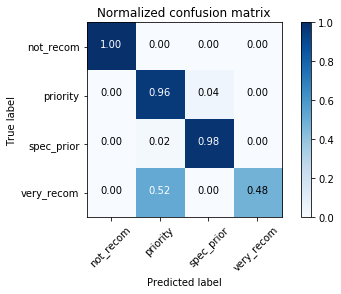

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 09:35:16 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 09:49:58 2018. Elapsed time (seconds) = 882.4337621231971

Compiling Training Results at: Sun May 13 09:49:58 2018...(please wait)
Results Completed at: Sun May 13 09:49:59 2018. Elapsed time (seconds) = 1.1534301886422327
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 09:49:59 2018

Best OOB Cohen's Kappa during tuning: 

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9627
Cohen's Kappa on unseen instances: 0.9452

Precision: [1.0, 0.93, 0.96, 0.92]
Recall: [1.0, 0.96, 0.98, 0.48]
F1 Score: [1.0, 0.94, 0.97, 0.63]
Support: [259, 255, 241, 23]

Confusion matrix, without normalization
[[259   0   0   0]
 [  0 244  10   1]
 [  0   6 235   0]
 [  0  12   0  11]]


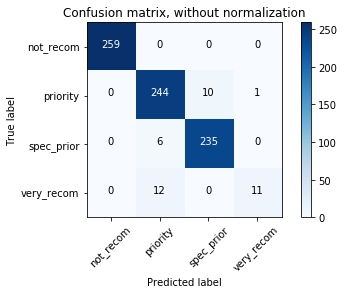

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.96 0.04 0.  ]
 [0.   0.02 0.98 0.  ]
 [0.   0.52 0.   0.48]]


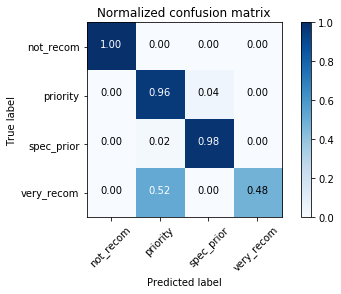

Working on Anchors for instance 222


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1521
Working on Anchors for instance 2159
Working on Anchors for instance 406
Working on Anchors for instance 1079
Working on Anchors for instance 1366
Working on Anchors for instance 536
Working on Anchors for instance 1451
Working on Anchors for instance 1466
Working on Anchors for instance 2480
Working on Anchors for instance 633
Working on Anchors for instance 89
Working on Anchors for instance 21
Working on Anchors for instance 1238
Working on Anchors for instance 1275
Working on Anchors for instance 274
Working on Anchors for instance 2389
Working on Anchors for instance 283
Working on Anchors for instance 2171
Working on Anchors for instance 931
Working on Anchors for instance 1215
Working on Anchors for instance 2248
Working on Anchors for instance 1911
Working on Anchors for instance 1270
Working on Anchors for instance 405
Working on Anchors for instance 1980
Working on Anchors for instance 1771
Working on Anchors for instance 923
Working on An

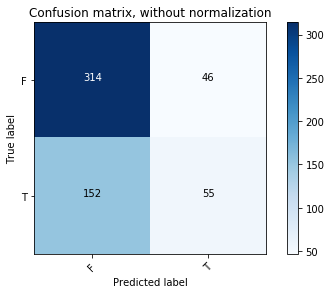

Normalized confusion matrix
[[0.87 0.13]
 [0.73 0.27]]


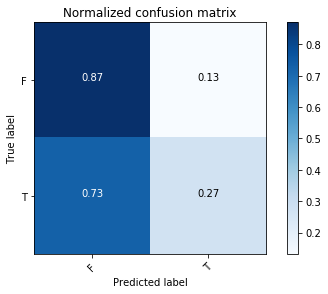

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 09:59:23 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 10:08:08 2018. Elapsed time (seconds) = 525.2777761418838

Compiling Training Results at: Sun May 13 10:08:08 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Results Completed at: Sun May 13 10:08:09 2018. Elapsed time (seconds) = 0.9760126269247849
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 10:08:09 2018

Best OOB Cohen's Kappa during tuning: 0.6495
Best parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 1500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.6490
Cohen's Kappa on unseen instances: 0.1376

Precision: [0.67, 0.55]
Recall: [0.89, 0.23]
F1 Score: [0.76, 0.33]
Support: [360, 207]

Confusion matrix, without normalization
[[320  40]
 [159  48]]


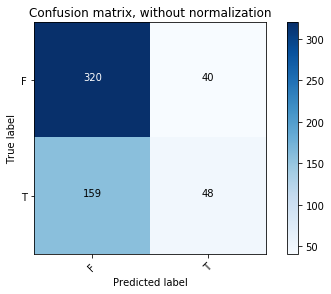

Normalized confusion matrix
[[0.89 0.11]
 [0.77 0.23]]


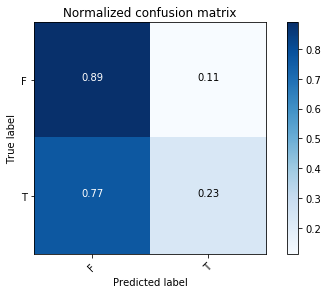

Working on Anchors for instance 992
Working on Anchors for instance 448
Working on Anchors for instance 397
Working on Anchors for instance 1182
Working on Anchors for instance 1185
Working on Anchors for instance 1554
Working on Anchors for instance 1429
Working on Anchors for instance 584


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 182
Working on Anchors for instance 134
Working on Anchors for instance 1697
Working on Anchors for instance 1878
Working on Anchors for instance 1497
Working on Anchors for instance 1661
Working on Anchors for instance 42
Working on Anchors for instance 1629
Working on Anchors for instance 1686
Working on Anchors for instance 1241
Working on Anchors for instance 903
Working on Anchors for instance 526
Working on Anchors for instance 1616
Working on Anchors for instance 941
Working on Anchors for instance 1256
Working on Anchors for instance 1220
Working on Anchors for instance 856
Working on Anchors for instance 841
Working on Anchors for instance 374
Working on Anchors for instance 195
Working on Anchors for instance 1635
Working on Anchors for instance 1689
Working on Anchors for instance 1521
Working on Anchors for instance 1503
Working on Anchors for instance 1786
Working on Anchors for instance 1260
Working on Anchors for instance 826
Working on An

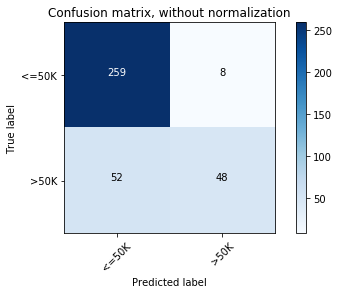

Normalized confusion matrix
[[0.97 0.03]
 [0.52 0.48]]


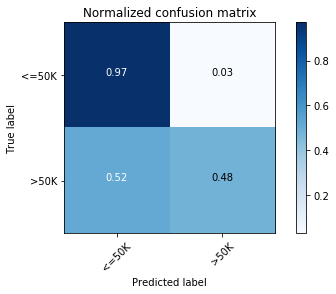

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 10:33:26 2018 with batch_size = 7 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 10:36:40 2018. Elapsed time (seconds) = 194.00897021326819

Compiling Training Results at: Sun May 13 10:36:40 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sun May 13 10:36:41 2018. Elapsed time (seconds) = 1.071579922150704
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 10:36:41 2018

Best OOB Cohen's Kappa during tuning: 0.8466
Best parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)


C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.8256
Cohen's Kappa on unseen instances: 0.4973

Precision: [0.83, 0.8]
Recall: [0.96, 0.48]
F1 Score: [0.89, 0.6]
Support: [267, 100]

Confusion matrix, without normalization
[[255  12]
 [ 52  48]]


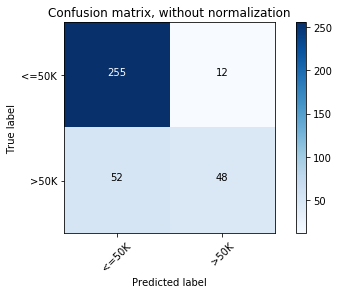

Normalized confusion matrix
[[0.96 0.04]
 [0.52 0.48]]


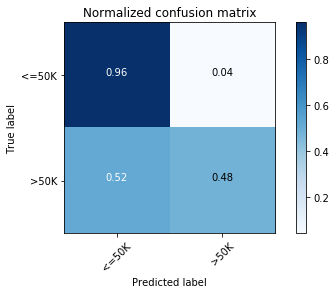

Working on Anchors for instance 528
Working on Anchors for instance 579


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1011
Working on Anchors for instance 1084
Working on Anchors for instance 320
Working on Anchors for instance 268
Working on Anchors for instance 436
Working on Anchors for instance 28
Working on Anchors for instance 1154
Working on Anchors for instance 722
Working on Anchors for instance 1107
Working on Anchors for instance 242
Working on Anchors for instance 348
Working on Anchors for instance 278
Working on Anchors for instance 494
Working on Anchors for instance 117
Working on Anchors for instance 18
Working on Anchors for instance 225
Working on Anchors for instance 810
Working on Anchors for instance 111
Working on Anchors for instance 818
Working on Anchors for instance 1153
Working on Anchors for instance 774
Working on Anchors for instance 273
Working on Anchors for instance 733
Working on Anchors for instance 483
Working on Anchors for instance 1135
Working on Anchors for instance 910
Working on Anchors for instance 427
Working on Anchors for i

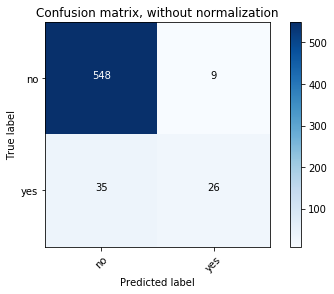

Normalized confusion matrix
[[0.98 0.02]
 [0.57 0.43]]


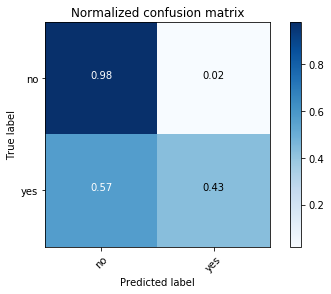

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 10:44:27 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 10:49:53 2018. Elapsed time (seconds) = 325.99272263130115

Compiling Training Results at: Sun May 13 10:49:53 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sun May 13 10:49:55 2018. Elapsed time (seconds) = 1.6875214460014831
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 10:49:55 2018

Best OOB Cohen's Kappa during tuning: 0.9126
Best parameters: {'max_depth': 16, 'min_samples_leaf': 5, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9175
Cohen's Kappa on unseen instances: 0.3516

Precision: [0.92, 0.73]
Recall: [0.99, 0.26]
F1 Score: [0.96, 0.39]
Support: [557, 61]

Confusion matrix, without normalization
[[551   6]
 [ 45  16]]


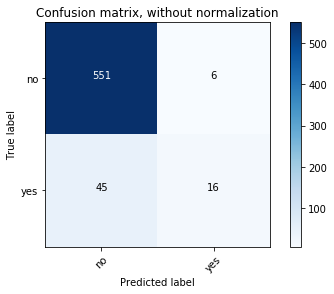

Normalized confusion matrix
[[0.99 0.01]
 [0.74 0.26]]


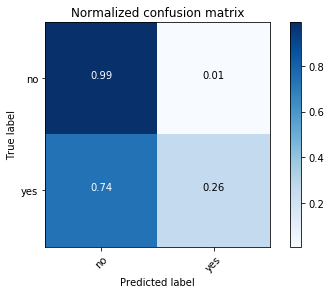

Working on Anchors for instance 782
Working on Anchors for instance 1728


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 834
Working on Anchors for instance 75
Working on Anchors for instance 1589
Working on Anchors for instance 1079
Working on Anchors for instance 1274
Working on Anchors for instance 246
Working on Anchors for instance 1044
Working on Anchors for instance 664
Working on Anchors for instance 1870
Working on Anchors for instance 1438
Working on Anchors for instance 674
Working on Anchors for instance 844
Working on Anchors for instance 428
Working on Anchors for instance 1471
Working on Anchors for instance 616
Working on Anchors for instance 288
Working on Anchors for instance 1225
Working on Anchors for instance 1485
Working on Anchors for instance 387
Working on Anchors for instance 309
Working on Anchors for instance 277
Working on Anchors for instance 340
Working on Anchors for instance 1106
Working on Anchors for instance 112
Working on Anchors for instance 1224
Working on Anchors for instance 563
Working on Anchors for instance 1806
Working on Anchor

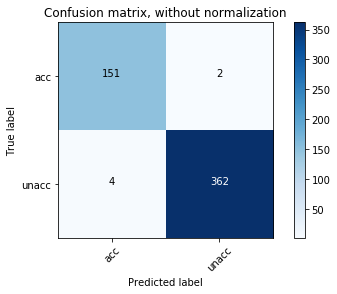

Normalized confusion matrix
[[0.99 0.01]
 [0.01 0.99]]


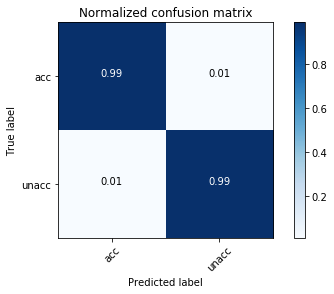

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 10:56:39 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 11:08:50 2

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9884
Cohen's Kappa on unseen instances: 0.9723

Precision: [0.97, 0.99]
Recall: [0.99, 0.99]
F1 Score: [0.98, 0.99]
Support: [153, 366]

Confusion matrix, without normalization
[[151   2]
 [  4 362]]


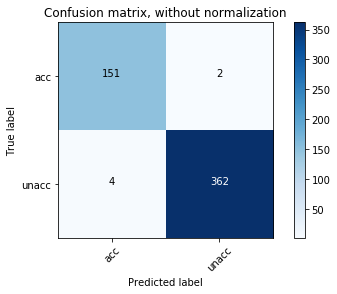

Normalized confusion matrix
[[0.99 0.01]
 [0.01 0.99]]


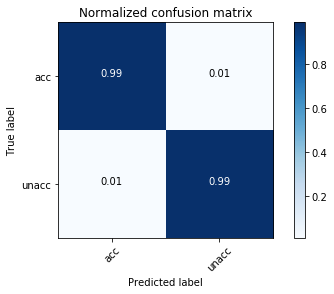

Working on Anchors for instance 1501
Working on Anchors for instance 258
Working on Anchors for instance 995
Working on Anchors for instance 1070
Working on Anchors for instance 610


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1171
Working on Anchors for instance 900
Working on Anchors for instance 113
Working on Anchors for instance 1296
Working on Anchors for instance 166
Working on Anchors for instance 926
Working on Anchors for instance 912
Working on Anchors for instance 167
Working on Anchors for instance 555
Working on Anchors for instance 595
Working on Anchors for instance 616
Working on Anchors for instance 1187
Working on Anchors for instance 1609
Working on Anchors for instance 1012
Working on Anchors for instance 846
Working on Anchors for instance 1492
Working on Anchors for instance 1604
Working on Anchors for instance 601
Working on Anchors for instance 726
Working on Anchors for instance 116
Working on Anchors for instance 279
Working on Anchors for instance 1154
Working on Anchors for instance 874
Working on Anchors for instance 1113
Working on Anchors for instance 888
Working on Anchors for instance 183
Working on Anchors for instance 153
Working on Anchors 

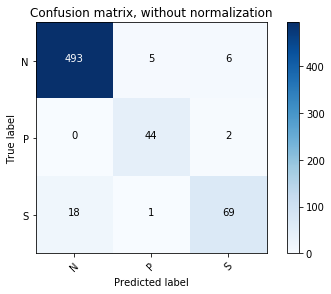

Normalized confusion matrix
[[0.98 0.01 0.01]
 [0.   0.96 0.04]
 [0.2  0.01 0.78]]


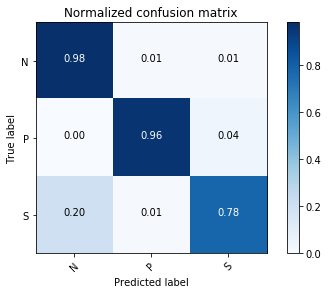

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 11:24:12 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 11:36:34 2018. Elapsed time (seconds) = 741.0118231701636

Compiling Training Results at: Sun May 13 11:36:34 2018...(please wait)
Results Completed at: Sun May 13 11:36:35 2018. Elapsed time (seconds) = 1.1725334317161469
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 11:36:35 2018

Best OOB Cohen's Kappa during tuning: 0.9368
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 1500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9091
Cohen's Kappa on unseen instances: 0.7286

Precision: [0.94, 0.88, 0.71]
Recall: [0.97, 0.8, 0.61]
F1 Score: [0.96, 0.84, 0.66]
Support: [504, 46, 88]

Confusion m

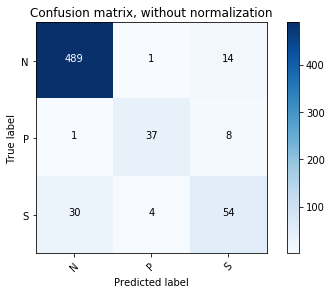

Normalized confusion matrix
[[0.97 0.   0.03]
 [0.02 0.8  0.17]
 [0.34 0.05 0.61]]


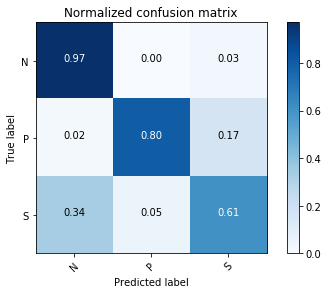

Working on Anchors for instance 2116
Working on Anchors for instance 315
Working on Anchors for instance 1043


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 316
Working on Anchors for instance 1897
Working on Anchors for instance 1725
Working on Anchors for instance 1708
Working on Anchors for instance 856
Working on Anchors for instance 1287
Working on Anchors for instance 329
Working on Anchors for instance 1875
Working on Anchors for instance 916
Working on Anchors for instance 627
Working on Anchors for instance 783
Working on Anchors for instance 1057
Working on Anchors for instance 175
Working on Anchors for instance 1687
Working on Anchors for instance 488
Working on Anchors for instance 284
Working on Anchors for instance 312
Working on Anchors for instance 1904
Working on Anchors for instance 894
Working on Anchors for instance 867
Working on Anchors for instance 1314
Working on Anchors for instance 1534
Working on Anchors for instance 880
Working on Anchors for instance 447
Working on Anchors for instance 2105
Working on Anchors for instance 1031
Working on Anchors for instance 1204
Working on Anch

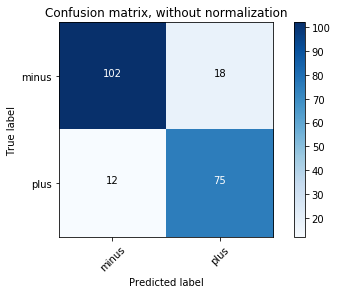

Normalized confusion matrix
[[0.85 0.15]
 [0.14 0.86]]


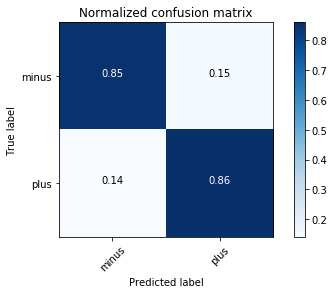

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 12:41:40 2018 with batch_size = 4 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 12:44:03 2018. Elapsed time (seconds) = 142.63530046638334

Compiling Training Results at: Sun May 13 12:44:03 2018...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Results Completed at: Sun May 13 12:44:04 2018. Elapsed time (seconds) = 0.7010152259899769
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 12:44:04 2018

Best OOB Cohen's Kappa during tuning: 0.8758
Best parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 500}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.8551
Cohen's Kappa on unseen instances: 0.7045

Precision: [0.89, 0.81]
Recall: [0.86, 0.85]
F1 Score: [0.87, 0.83]
Support: [120, 87]

Confusion matrix, without normalization
[[103  17]
 [ 13  74]]


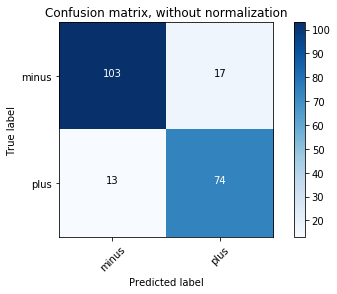

Normalized confusion matrix
[[0.86 0.14]
 [0.15 0.85]]


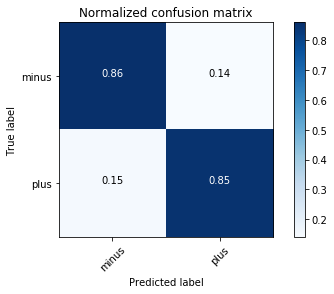

Working on Anchors for instance 310
Working on Anchors for instance 642
Working on Anchors for instance 423


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 407
Working on Anchors for instance 236
Working on Anchors for instance 557
Working on Anchors for instance 259
Working on Anchors for instance 512
Working on Anchors for instance 542
Working on Anchors for instance 625
Working on Anchors for instance 156
Working on Anchors for instance 629
Working on Anchors for instance 548
Working on Anchors for instance 126
Working on Anchors for instance 436
Working on Anchors for instance 579
Working on Anchors for instance 575
Working on Anchors for instance 396
Working on Anchors for instance 650
Working on Anchors for instance 205
Anchors Done. Completed run at: Sun May 13 12:47:44 2018. Elapsed time (seconds) = 220.15561640395026

Results saved at whiteboxing\credit_pickles\results.pickle

To retrieve results execute the following:
results_store = open('whiteboxing\credit_pickles\results.pickle', "rb")
results = pickle.load(results_store)
results_store.close()

LOADING NEW DATA SET.

Finding best parameters for

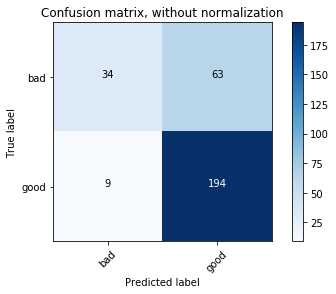

Normalized confusion matrix
[[0.35 0.65]
 [0.04 0.96]]


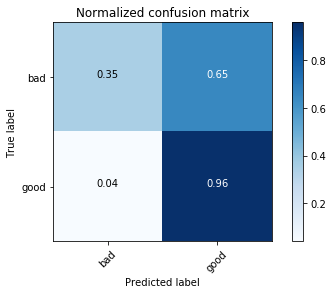

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 12:48:06 2018 with batch_size = 6 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 12:52:52 2018. Elapsed time (seconds) = 285.7474290336395

Compiling Training Results at: Sun May 13 12:52:52 2018...(please wait)
Results Completed at: Sun May 13 12:52:53 2018. Elapsed time (seconds) = 1.419941732980078
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 12:52:53 2018

Best OOB Cohen's Kappa dur

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.7567
Cohen's Kappa on unseen instances: 0.3389

Precision: [0.82, 0.75]
Recall: [0.32, 0.97]
F1 Score: [0.46, 0.84]
Support: [97, 203]

Confusion matrix, without normalization
[[ 31  66]
 [  7 196]]


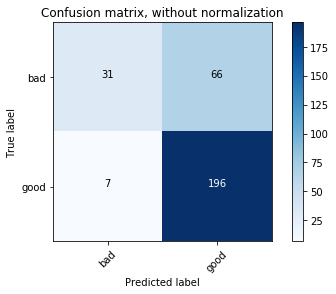

Normalized confusion matrix
[[0.32 0.68]
 [0.03 0.97]]


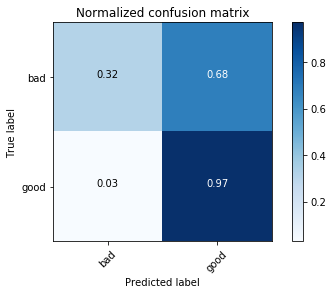

Working on Anchors for instance 688
Working on Anchors for instance 596


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 7
Working on Anchors for instance 685
Working on Anchors for instance 724
Working on Anchors for instance 446
Working on Anchors for instance 365
Working on Anchors for instance 778
Working on Anchors for instance 206
Working on Anchors for instance 20
Working on Anchors for instance 448
Working on Anchors for instance 268
Working on Anchors for instance 721
Working on Anchors for instance 221
Working on Anchors for instance 956
Working on Anchors for instance 794
Working on Anchors for instance 578
Working on Anchors for instance 249
Working on Anchors for instance 853
Working on Anchors for instance 917
Working on Anchors for instance 195
Working on Anchors for instance 868
Working on Anchors for instance 310
Working on Anchors for instance 856
Working on Anchors for instance 713
Working on Anchors for instance 439
Working on Anchors for instance 938
Working on Anchors for instance 577
Working on Anchors for instance 522
Working on Anchors for instance

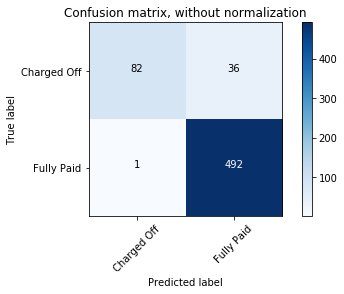

Normalized confusion matrix
[[0.69 0.31]
 [0.   1.  ]]


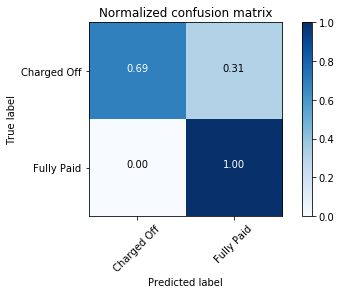

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 13:00:06 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 13:08:44 2018. Elapsed time (seconds) = 518.2337892255309

Compiling Training Results at: Sun May 13 13:08:44 2018...(please wait)
Results Completed at: Sun May 13 13:08:46 2018. Elapsed time (seconds) = 2.3194166927569313
Whiteboxing Randfor Done

Processing Anchors
Startin

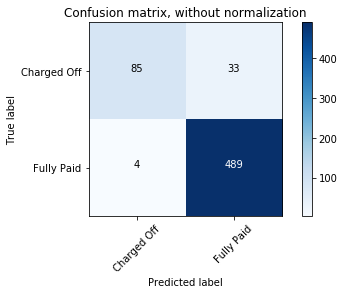

Normalized confusion matrix
[[0.72 0.28]
 [0.01 0.99]]


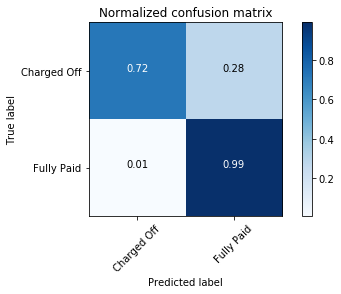

Working on Anchors for instance 1202


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 1867
Working on Anchors for instance 1306
Working on Anchors for instance 1106
Working on Anchors for instance 629
Working on Anchors for instance 829
Working on Anchors for instance 175
Working on Anchors for instance 273
Working on Anchors for instance 714
Working on Anchors for instance 1705
Working on Anchors for instance 1390
Working on Anchors for instance 48
Working on Anchors for instance 1932
Working on Anchors for instance 1036
Working on Anchors for instance 1174
Working on Anchors for instance 1889
Working on Anchors for instance 354
Working on Anchors for instance 131
Working on Anchors for instance 1840
Working on Anchors for instance 1254
Working on Anchors for instance 938
Working on Anchors for instance 502
Working on Anchors for instance 112
Working on Anchors for instance 1142
Working on Anchors for instance 328
Working on Anchors for instance 157
Working on Anchors for instance 1949
Working on Anchors for instance 1972
Working on Anch

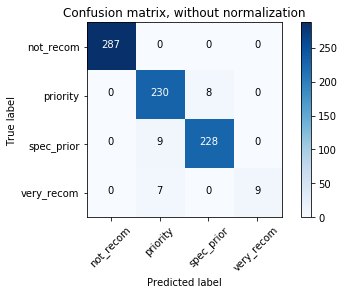

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.97 0.03 0.  ]
 [0.   0.04 0.96 0.  ]
 [0.   0.44 0.   0.56]]


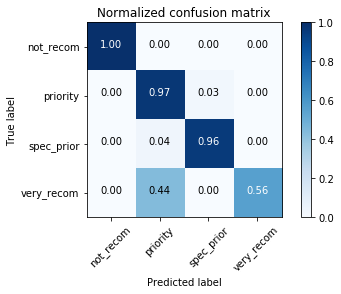

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 14:48:31 2018 with batch_size = 10 and n_batches = 50...(please wait)
done batch 0
done batch 1
done batch 2
done batch 3
done batch 4


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11
done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 15:02:42 2018. Elapsed time (seconds) = 851.455531130734

Compiling Training Results at: Sun May 13 15:02:42 2018...(please wait)
Results Completed at: Sun May 13 15:02:44 2018. Elapsed time (seconds) = 1.1207697665231535
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 15:02:44 2018

Best OOB Cohen's Kappa dur

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.9692
Cohen's Kappa on unseen instances: 0.9543

Precision: [1.0, 0.93, 0.97, 1.0]
Recall: [1.0, 0.97, 0.96, 0.56]
F1 Score: [1.0, 0.95, 0.96, 0.72]
Support: [287, 238, 237, 16]

Confusion matrix, without normalization
[[287   0   0   0]
 [  0 230   8   0]
 [  0   9 228   0]
 [  0   7   0   9]]


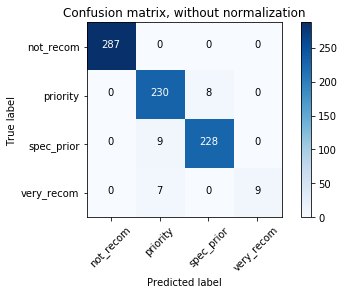

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.97 0.03 0.  ]
 [0.   0.04 0.96 0.  ]
 [0.   0.44 0.   0.56]]


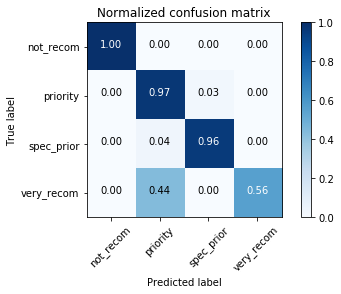

Working on Anchors for instance 346
Working on Anchors for instance 100


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 70
Working on Anchors for instance 169
Working on Anchors for instance 2469
Working on Anchors for instance 217
Working on Anchors for instance 1628
Working on Anchors for instance 519
Working on Anchors for instance 1651
Working on Anchors for instance 2481
Working on Anchors for instance 2355
Working on Anchors for instance 1351
Working on Anchors for instance 190
Working on Anchors for instance 510
Working on Anchors for instance 1566
Working on Anchors for instance 2450
Working on Anchors for instance 933
Working on Anchors for instance 679
Working on Anchors for instance 2461
Working on Anchors for instance 2148
Working on Anchors for instance 692
Working on Anchors for instance 1689
Working on Anchors for instance 202
Working on Anchors for instance 2395
Working on Anchors for instance 1984
Working on Anchors for instance 1448
Working on Anchors for instance 1821
Working on Anchors for instance 850
Working on Anchors for instance 661
Working on Anc

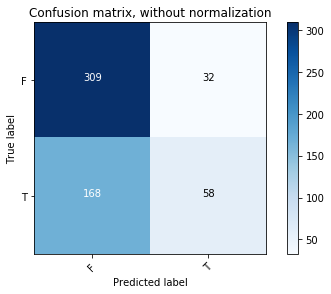

Normalized confusion matrix
[[0.91 0.09]
 [0.74 0.26]]


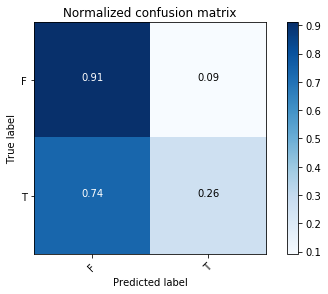

NOTE: During run, true divide errors are acceptable.
    Returned when a tree does not contain any node for either/both upper and lower bounds of a feature.

    
Starting new run at: Sun May 13 15:11:27 2018 with batch_size = 10 and n_batches = 50...(please wait)


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:272: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(uppers, upper_bins)[0]).round(5)
C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:276: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(lowers, lower_bins)[0]).round(5)


done batch 0
done batch 1
done batch 2
done batch 3
done batch 4
done batch 5
done batch 6
done batch 7
done batch 8
done batch 9
done batch 10
done batch 11


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\structures.py:789: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)
C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


done batch 12
done batch 13
done batch 14
done batch 15
done batch 16
done batch 17
done batch 18
done batch 19
done batch 20
done batch 21
done batch 22
done batch 23
done batch 24
done batch 25
done batch 26
done batch 27
done batch 28
done batch 29
done batch 30
done batch 31
done batch 32
done batch 33
done batch 34
done batch 35
done batch 36
done batch 37
done batch 38
done batch 39
done batch 40
done batch 41
done batch 42
done batch 43
done batch 44
done batch 45
done batch 46
done batch 47
done batch 48
done batch 49
Done. Completed run at: Sun May 13 15:15:26 2018. Elapsed time (seconds) = 239.38834256876726

Compiling Training Results at: Sun May 13 15:15:26 2018...(please wait)
Results Completed at: Sun May 13 15:15:27 2018. Elapsed time (seconds) = 0.9938412788469577
Whiteboxing Randfor Done

Processing Anchors
Starting new run at: Sun May 13 15:15:27 2018

Best OOB Cohen's Kappa during tuning: 0.6563
Best parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators':

C:\Users\id126493\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model

Accuracy on unseen instances: 0.6296
Cohen's Kappa on unseen instances: 0.1301

Precision: [0.63, 0.61]
Recall: [0.91, 0.2]
F1 Score: [0.75, 0.3]
Support: [341, 226]

Confusion matrix, without normalization
[[311  30]
 [180  46]]


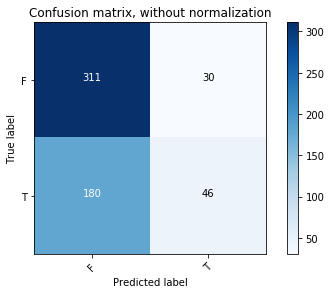

Normalized confusion matrix
[[0.91 0.09]
 [0.8  0.2 ]]


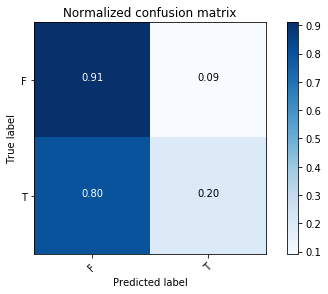

Working on Anchors for instance 300
Working on Anchors for instance 1293
Working on Anchors for instance 97
Working on Anchors for instance 324
Working on Anchors for instance 144
Working on Anchors for instance 1326
Working on Anchors for instance 224
Working on Anchors for instance 70
Working on Anchors for instance 1003


C:\Users\id126493\Documents\GitHub\interpret_basics2\forest_surveyor\routines.py:651: RuntimeWarning: invalid value encountered in true_divide
  plaus /= np.sum(plaus)


Working on Anchors for instance 838
Working on Anchors for instance 149
Working on Anchors for instance 1156
Working on Anchors for instance 1505
Working on Anchors for instance 971
Working on Anchors for instance 776
Working on Anchors for instance 643
Working on Anchors for instance 155
Working on Anchors for instance 944
Working on Anchors for instance 1777
Working on Anchors for instance 1576
Working on Anchors for instance 481
Working on Anchors for instance 1026
Working on Anchors for instance 1854
Working on Anchors for instance 1028
Working on Anchors for instance 35
Working on Anchors for instance 1361
Working on Anchors for instance 890
Working on Anchors for instance 163
Working on Anchors for instance 1481
Working on Anchors for instance 1542
Working on Anchors for instance 1214
Working on Anchors for instance 385
Working on Anchors for instance 1134
Working on Anchors for instance 1166
Working on Anchors for instance 1174
Working on Anchors for instance 86
Working on Ancho

In [2]:
n_instances=500
n_batches=50
support_paths=0.05
alpha_paths=0.3
alpha_scores=0.75
which_trees='majority'
precis_threshold=0.95                                  
eval_model=True
run_anchors=True

for random_state in [123, 124, 125, 126, 127]:

    grid_experiment(n_instances,
                    n_batches,
                    random_state=random_state,
                    override_tuning=True,
                    support_paths=support_paths,
                    alpha_paths=alpha_paths,
                    alpha_scores=alpha_scores,
                    which_trees=which_trees,
                    precis_threshold=precis_threshold,
                    eval_model=eval_model,
                    run_anchors=run_anchors)

In [7]:
import numpy as np
if any(np.array([])):
    print('true')

# LIME

In [12]:
import numpy as np
mydata=dataset()
tt = mydata.tt_split()

np.random.seed(mydata.random_state)

explainer = limtab.LimeTabularExplainer(training_data=np.array(tt['X_train'].todense())
                                        , feature_names=mydata.onehot_features
                                        , training_labels=['y_train']
                                        , class_names=mydata.class_names
                                        , categorical_features=mydata.categorical_features
                                        , categorical_names=mydata.onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

if tt['encoder'] is None:
    instance = tt['X_test'][0:1]
else:
    instance = tt['encoder'].transform(tt['X_test'][0:1]).todense()

# exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
exp = explainer.explain_instance(np.array(instance)[0]
                                 , enc_model.predict_proba
                                 , top_labels=4)

C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


NameError: name 'rf' is not defined

# Part 1. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [ ]:
from forest_surveyor.plotting import rule_profile_plots
i = 4
alpha_scores = 0.75
rule_profile_plots(rule_acc[i], ds.rcdv_samp_data().class_names, ig=False, cp=True, alpha_scores=alpha_scores)

[results[i][ra].pruned_rule for ra in range(6)]
[results[r][ra].pruned_rule for r in range(len(results)) for ra in range(3)]

# Part 2. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [ ]:
# run the full forest survey
tt_correct_stats, tt_incorrect_stats = cor_incor_forest_survey(
 f_walker = f_walker, X=tt['X_test'], y=tt['y_test'])

In [ ]:
plot_mean_path_lengths(forest_stats=tt_correct_stats, class_names=mydata.class_names)
plot_mean_path_lengths(forest_stats=tt_incorrect_stats, class_names=mydata.class_names)

In [ ]:
plot_varimp(rf, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_root_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_child_traversals', mydata.class_names, mydata.onehot_features)
plot_feature_stats(tt_correct_stats, 'p_lower_traversals', mydata.class_names, mydata.onehot_features)

In [ ]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_child_traversals']
                            , num_err = tt_correct_stats[0]['se_child_traversals']
                            , denom = tt_incorrect_stats[0]['m_child_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_child_traversals']
                            , labels = mydata.onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = mydata.onehot_features
)

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [ ]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

In [ ]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
interp = interp.sort_values('bad', ascending=False).reset_index().drop('index', axis=1)
interp

In [ ]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

## LIME

In [ ]:
fig = exp.as_pyplot_figure(label=pred_class_code)

exp.as_list(label=pred_class_code)

In [ ]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [ ]:
exp.show_in_notebook()